In [1]:
import math
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator
import imageio.v3 as iio

C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SRC = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input'

In [5]:
videos = [file for file in os.listdir(SRC) if file.endswith("MP4") and file.startswith("GX")]

In [6]:
videos

['GX010001.MP4',
 'GX010004.MP4',
 'GX010006_cely-zavit_std-nastaveni.MP4',
 'GX010007_cely zavit RGBW.MP4',
 'GX010008_cely zavit RGaW.MP4',
 'GX010009_cely zavit clona nahoru.MP4',
 'GX010010.MP4',
 'GX010011.MP4',
 'GX010012.MP4',
 'GX010014.MP4',
 'GX010015.MP4',
 'GX010016.MP4',
 'GX010017.MP4',
 'GX010981.MP4',
 'GX010987.MP4']

In [7]:
vidcap = cv2.VideoCapture(os.path.join(SRC, videos[-2]))

In [8]:
vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

12031.0

In [19]:
frames = []
start = 3100
step = 60
amount = 1
end = start + step*amount
for i in range(start, end, step):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = vidcap.read()
    frames.append(frame)

In [35]:
detail_x = [1700,2300]
detail_y = [1500,1800]

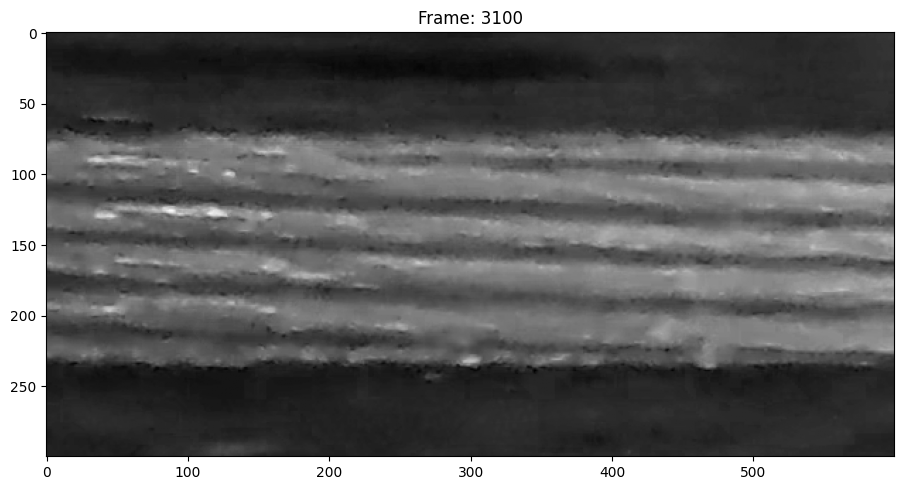

In [36]:
columns = 1
rows = math.ceil(len(frames) / columns)
plt.figure(figsize=(12, rows*5))
for i, frame in enumerate(frames):
    ax = plt.subplot(rows, columns, i+1)
    ax.imshow(frame[detail_y[0]:detail_y[1], detail_x[0]:detail_x[1],0], cmap="gray")
    ax.set_title(f"Frame: {start + step*i}")
plt.tight_layout()
plt.show()
plt.close()

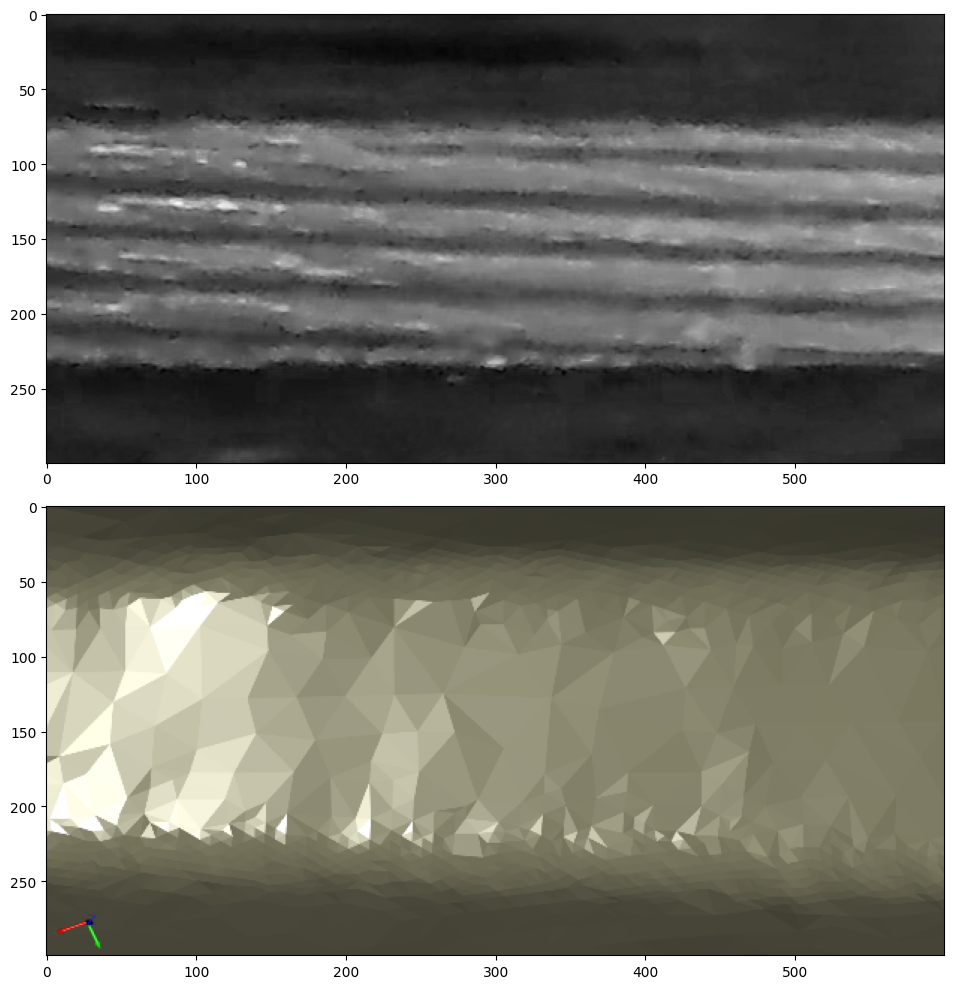

In [39]:
plt.figure(figsize=(12, 10))
ax = plt.subplot(211)
ax.imshow(frame[detail_y[0]:detail_y[1], detail_x[0]:detail_x[1],0], cmap="gray")
img = iio.imread('C:/Users/fathe/OneDrive/Pictures/Snímky obrazovky/Screenshot 2024-12-27 144008.png')
ax = plt.subplot(212)
ax.imshow(cv2.resize(img, (600,300)), cmap="gray")
plt.tight_layout()
plt.show()
plt.close()

In [7]:
def win_path_to_unix_path(path):
    """
    Converts a Windows-style path to a Unix-style path.

    Args:
        path (str): Windows-style path.

    Returns:
        str: Unix-style path.
    """
    return path.replace("\\", "/").replace("C:/", "/mnt/c/")

In [12]:
Y1 = 550 #700    # Y1-PADDING cant be lower then 0
Y2 = 1850 #1900   # Y2+PADDING cant be bigger then 2160
X1 = 1350 #1500   # X1-PADDING cant be lower then 0
X2 = 2650 #2700   # X2+PADDING cant be bigger then 3840
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 200)
success, frame = vidcap.read()
cropped_frame = frame[Y1:Y2, X1:X2, 0]
cropped_frame = cv2.resize(cropped_frame, (cropped_frame.shape[0] // 4, cropped_frame.shape[1] // 4))
otsu_threshold, _ = cv2.threshold(cropped_frame, 0, 255, cv2.THRESH_OTSU)
print(otsu_threshold)

iio.imwrite("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/text/img/cropped.pgm", cropped_frame)
iio.imwrite("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/text/img/cropped.png", cropped_frame)

process = subprocess.Popen(
    ["wsl", "devernay", "/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/text/img/cropped.pgm",
     "-l", f"{otsu_threshold / 15}",
     "-h", f"{otsu_threshold / 3}",
     "-p", f"/mnt/c/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/text/img/devernay.pdf",
     "-s", f"1.5"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for the process to complete and get stdout and stderr
stdout, stderr = process.communicate()

117.0


UnidentifiedImageError: cannot identify image file 'C:\\Users\\fathe\\OneDrive\\Documents\\UK\\MFF\\Thesis\\text\\img\\devernay.svg'

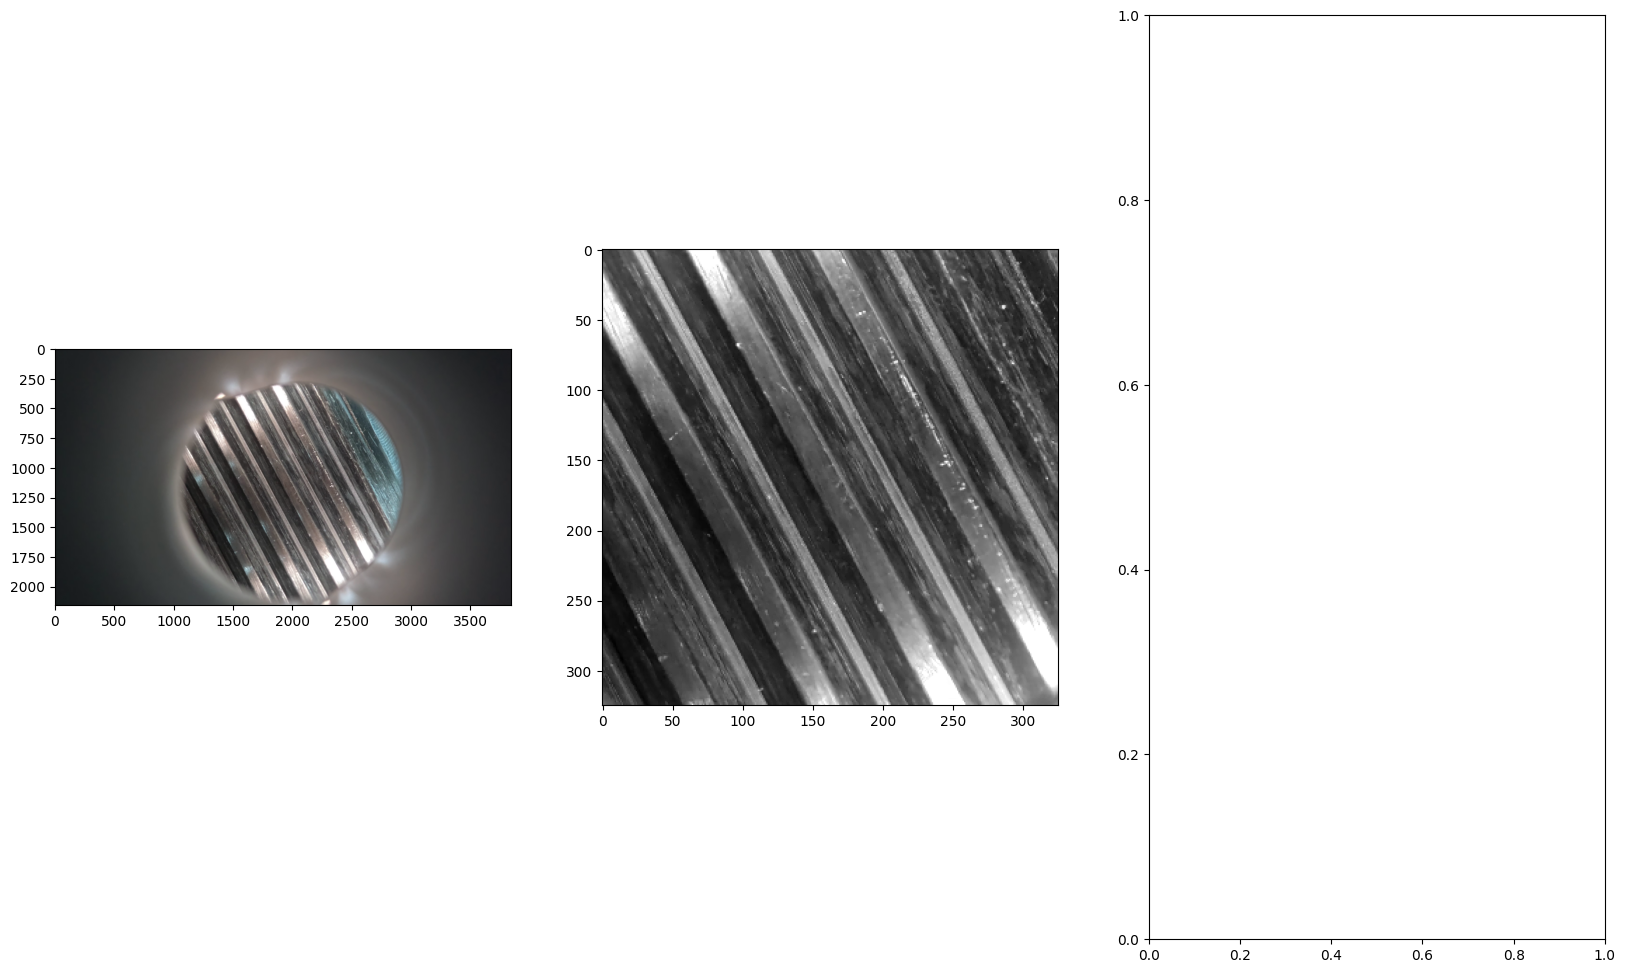

In [11]:
from matplotlib import image as mpimg

plt.figure(figsize=(20,12))
ax = plt.subplot(131)
ax.imshow(frame, cmap="gray")
ax = plt.subplot(132)
ax.imshow(cropped_frame, cmap="gray")
ax = plt.subplot(133)
img = mpimg.imread("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/text/img/devernay.svg")
ax.imshow(img)

In [9]:
stat, img = vidcap.read()

In [8]:
iio.imwrite("test.png", img)

In [11]:
shift_matrix = np.float32([
[1, 0, 0.5],
[0, 1, 0]
])

In [12]:
aligned_image = cv2.warpAffine(img, shift_matrix, (3840 + 1, 2160))

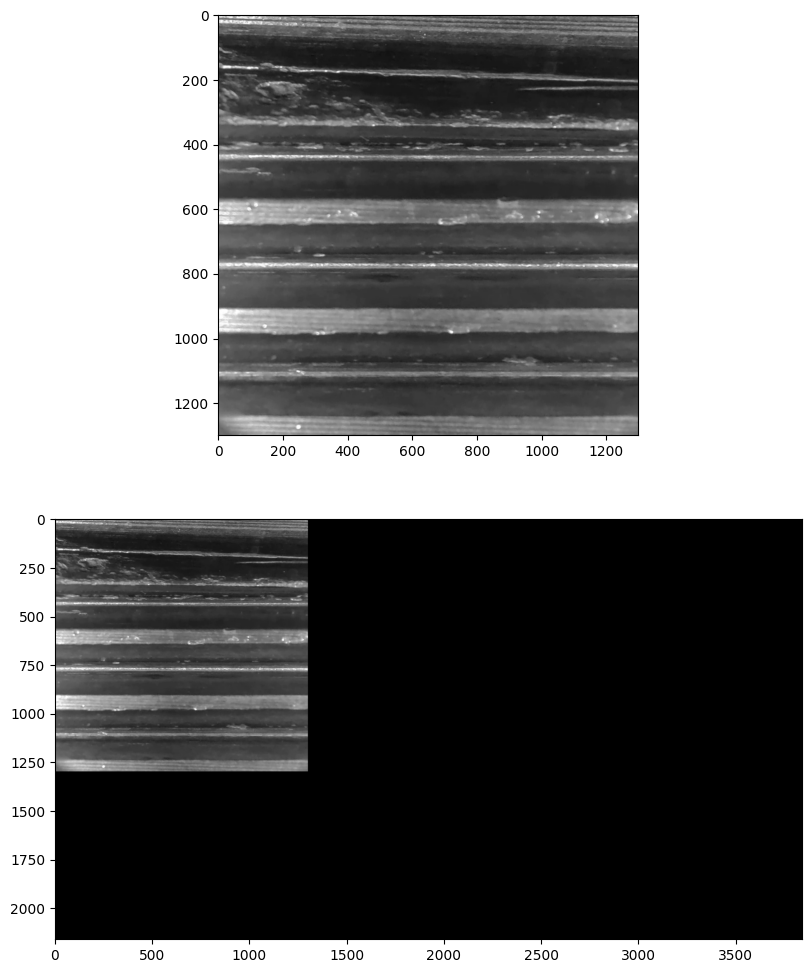

In [13]:
plt.figure(figsize=(20,12))
ax = plt.subplot(211)
ax.imshow(img, cmap="gray")
ax = plt.subplot(212)
ax.imshow(aligned_image, cmap="gray")

In [22]:
video_timing = []
for video in videos:
    # taken from palivo - list timing of the video
    _cmd = ["ffprobe",
        "-i", str(os.path.join(SRC, video)),
        "-show_frames",
        "-show_entries", "frame=pkt_dts_time:side_data=",
        "-select_streams", "v:0",
        "-print_format", "flat"]
    video_info_file_path = os.path.join(SRC, video.replace(".MP4", "-video-info.txt"))
    if not os.path.isfile(video_info_file_path):    
        with open(video_info_file_path, 'w') as f:
            p1 = subprocess.call(_cmd, stdout=f)
    with open(video_info_file_path, "rt") as f:
        video_timing.append(f.readlines())

In [23]:
timings = []
for vt in video_timing:
    timing = []
    for frame in vt:
        single_line = frame.rstrip("\n")
        timestamp = float(single_line.split('"')[1])
        frameNo = int(single_line.split(".")[2])
        timing.append((frameNo, timestamp))
    timings.append(timing)

In [18]:
print("Standard deviation in frame timing:", np.std([frameNo / timestamp for frameNo, timestamp in timing[1:]]))

Standard deviation in frame timing: 2.4677695913658456e-06


timing seems constant

# Show some frames

In [6]:
vidcap = cv2.VideoCapture(os.path.join(SRC, videos[-2]))

In [20]:
len(timing) / 25, videos[-2]

(352.64, 'GX010998.MP4')

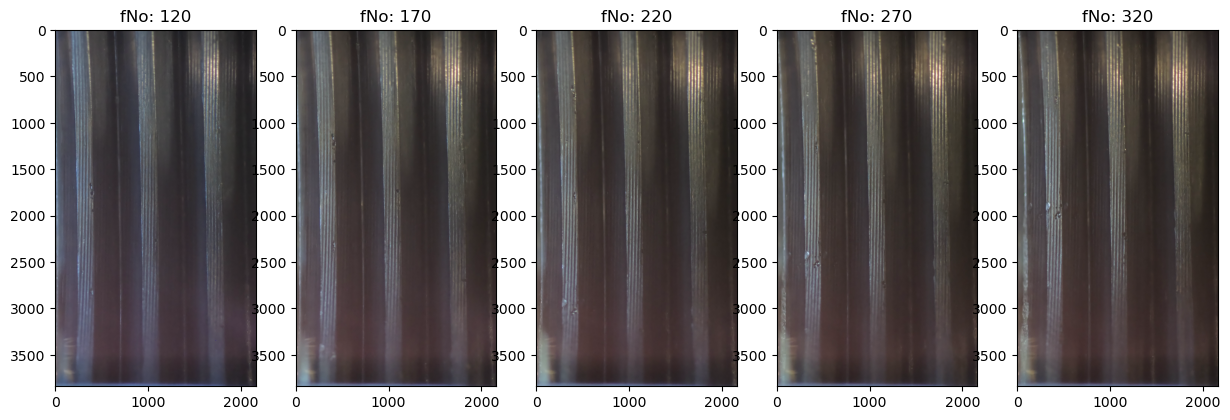

In [21]:
begin_frame = 120
step = 50
plt.figure(figsize=(15,5))
for i in range(1,6):
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, begin_frame + (i - 1) * step)
    success, image = vidcap.read()
    if success:
        ax = plt.subplot(1,5,i)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(f"fNo: {begin_frame + (i-1) * step}")        
plt.show()

## Light level

In [22]:
frame_lights = []

for video in videos:
    video_light_file_path = os.path.join(SRC, video.replace(".MP4", "-light_levels.npy"))
    if not os.path.isfile(video_light_file_path):
        vidcap = cv2.VideoCapture(os.path.join(SRC, video))
        # Initialize the progress bar
        total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        pbar = tqdm(total=total_frames, desc=f"Extracting light levels for {video}")
        frame_light = []
        success, image = vidcap.read()
        while success:
            frame_light.append(np.sum(image))
            success, image = vidcap.read() 
            pbar.update(1)
        np.save(video_light_file_path, frame_light)
    frame_lights.append(np.load(video_light_file_path))

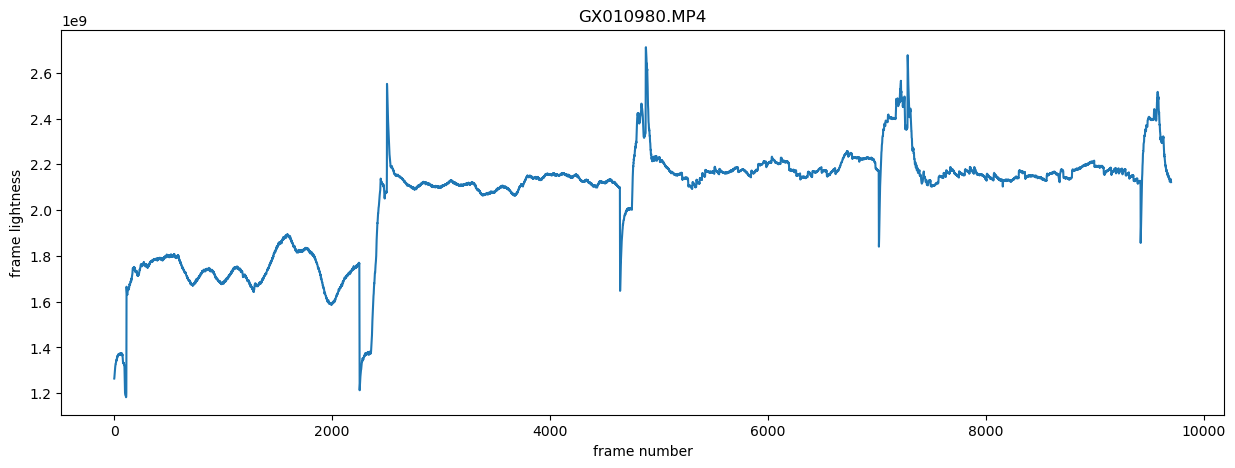

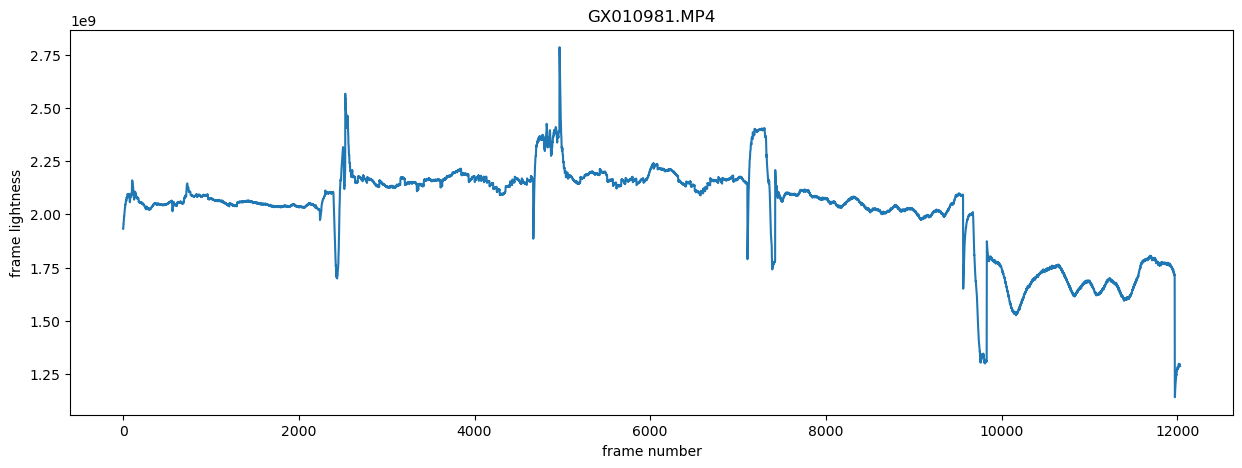

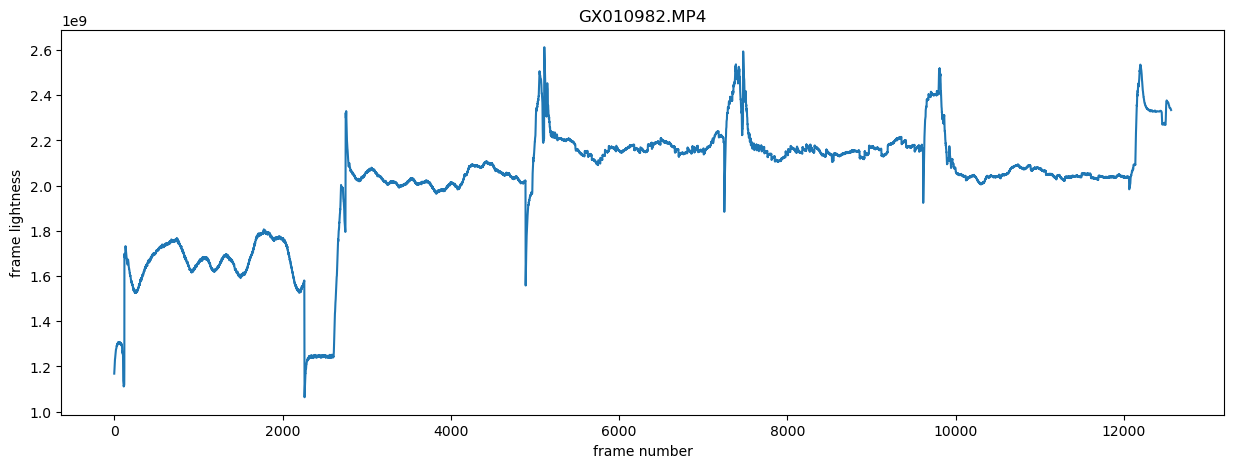

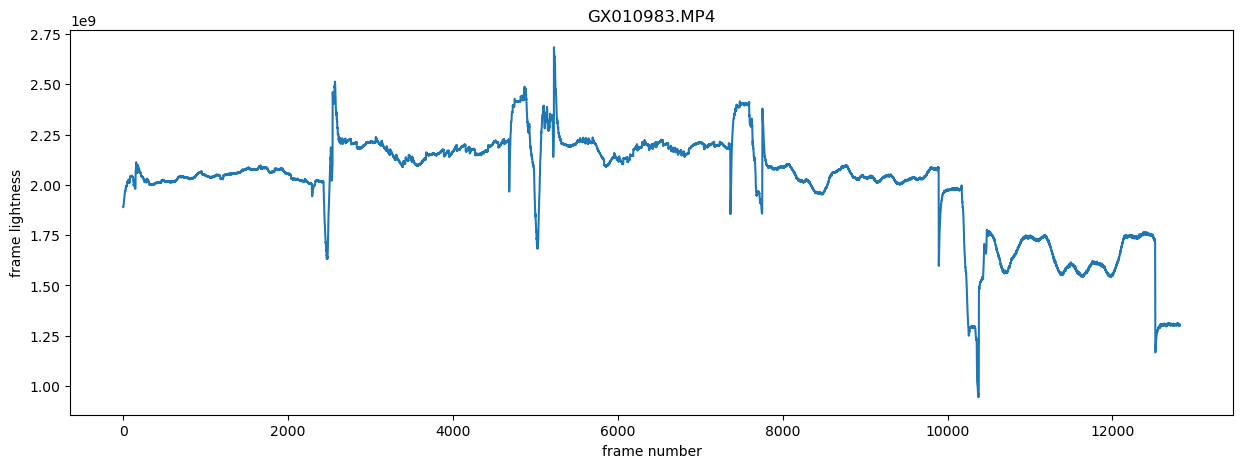

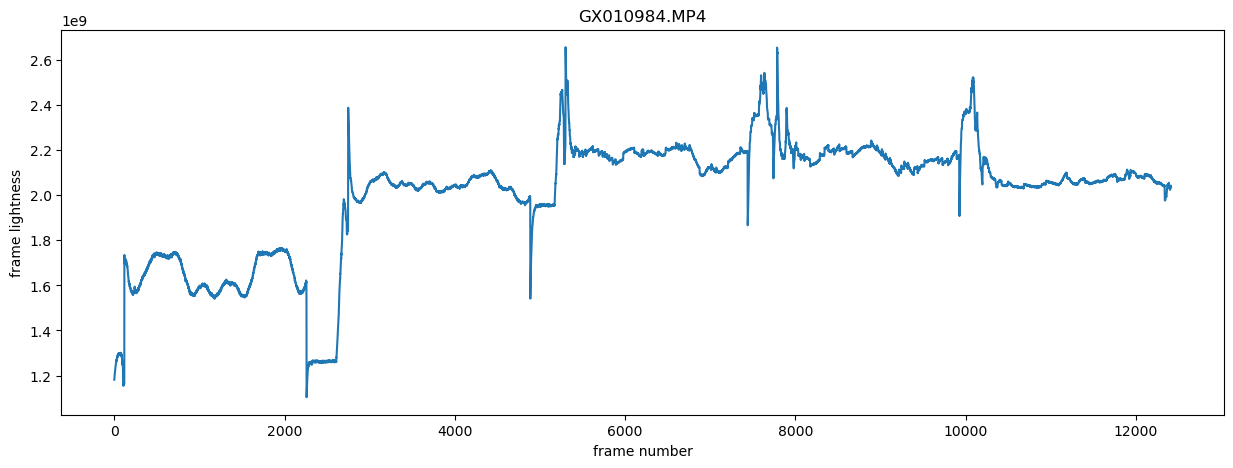

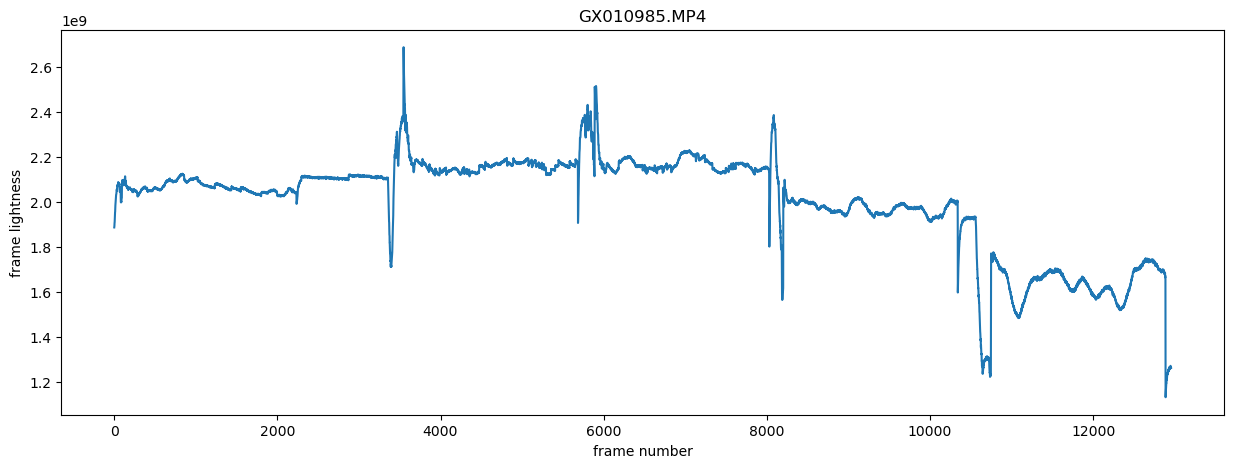

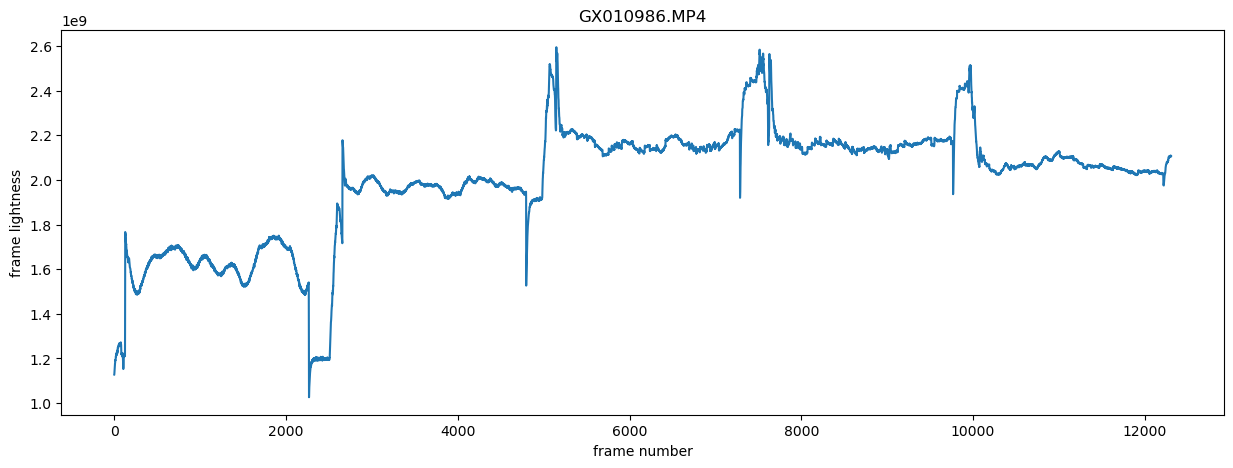

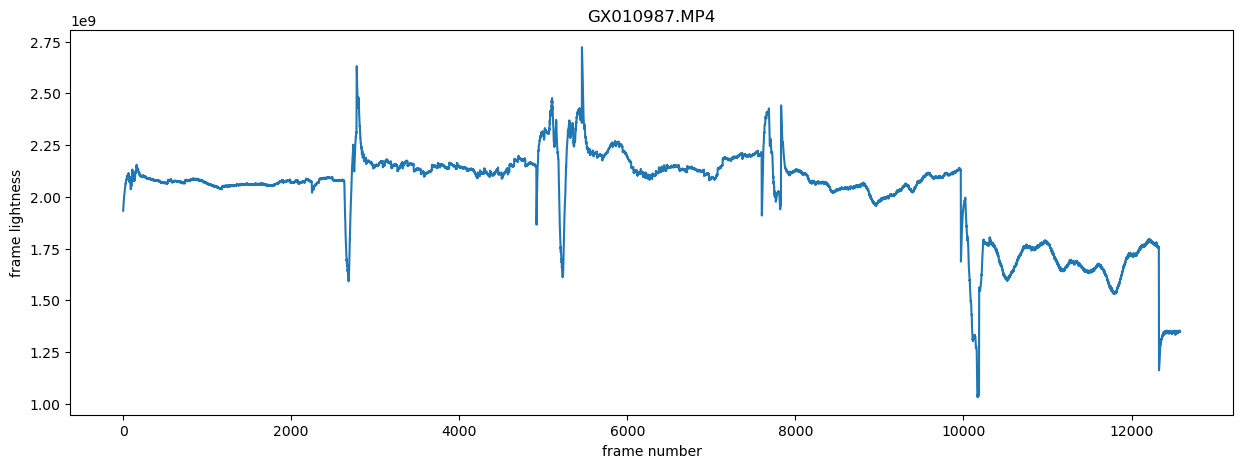

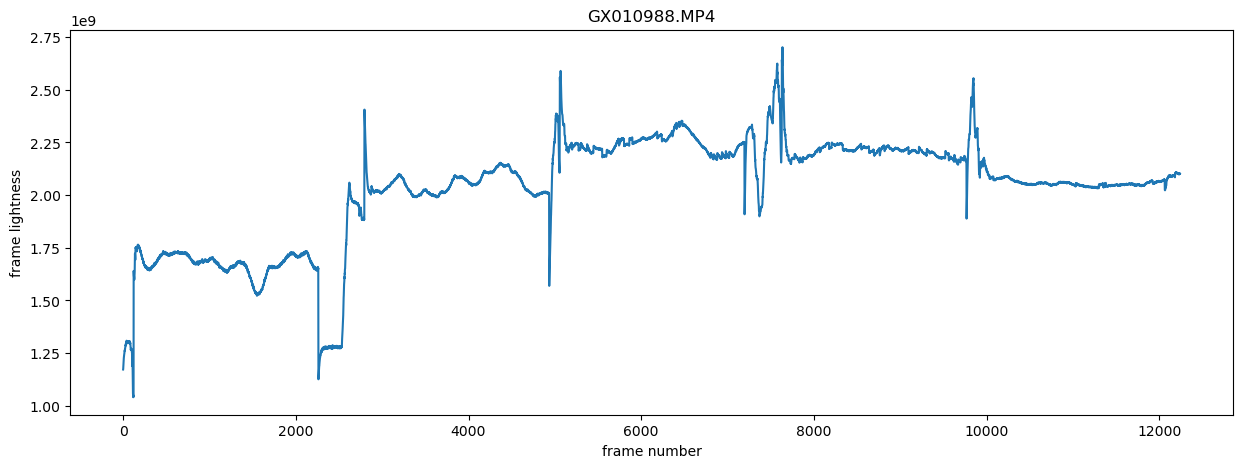

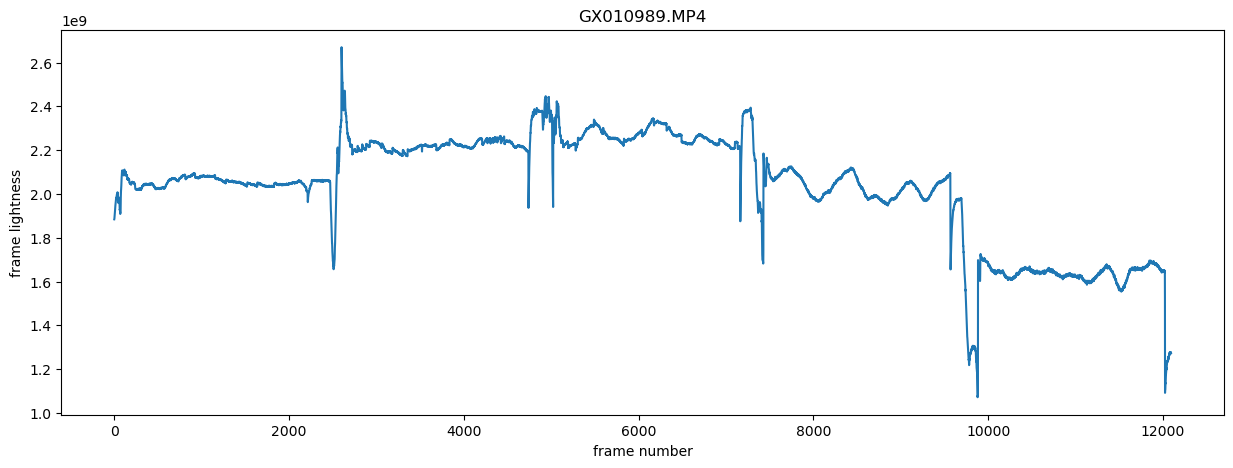

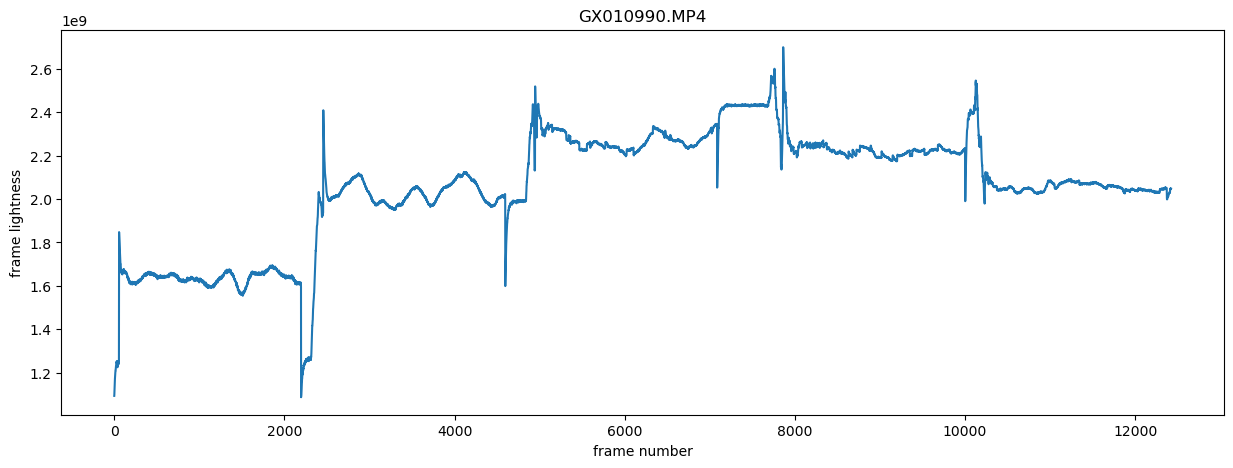

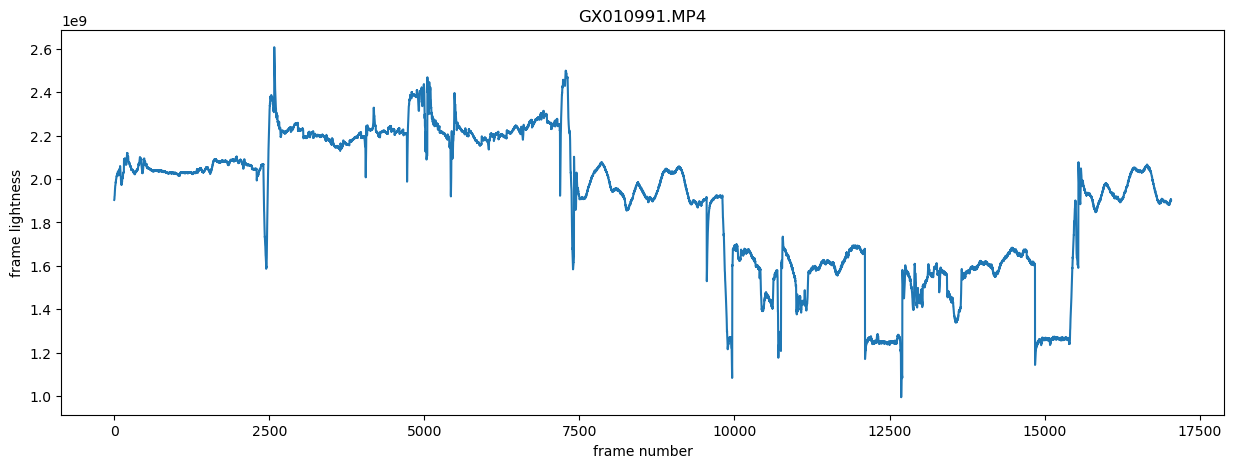

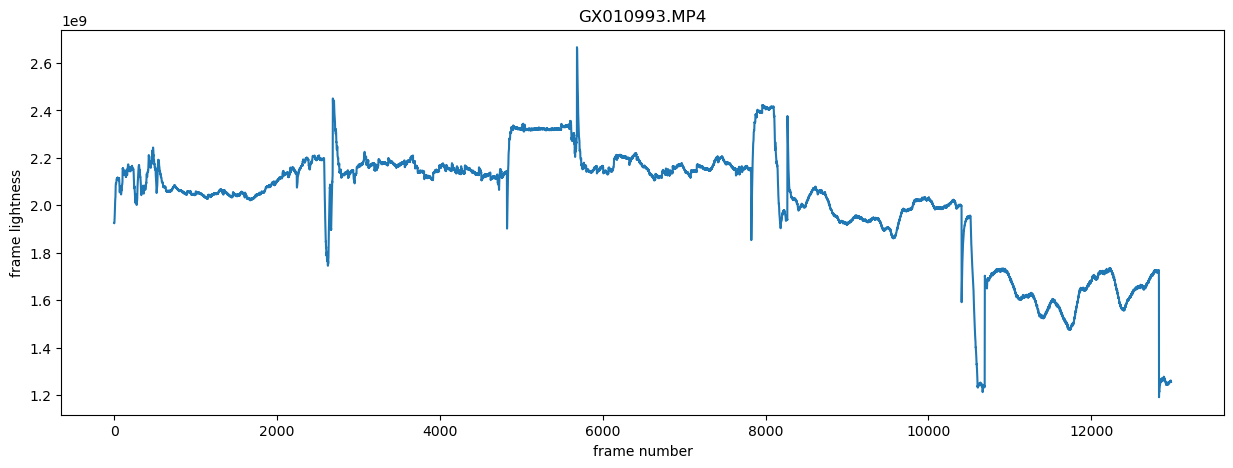

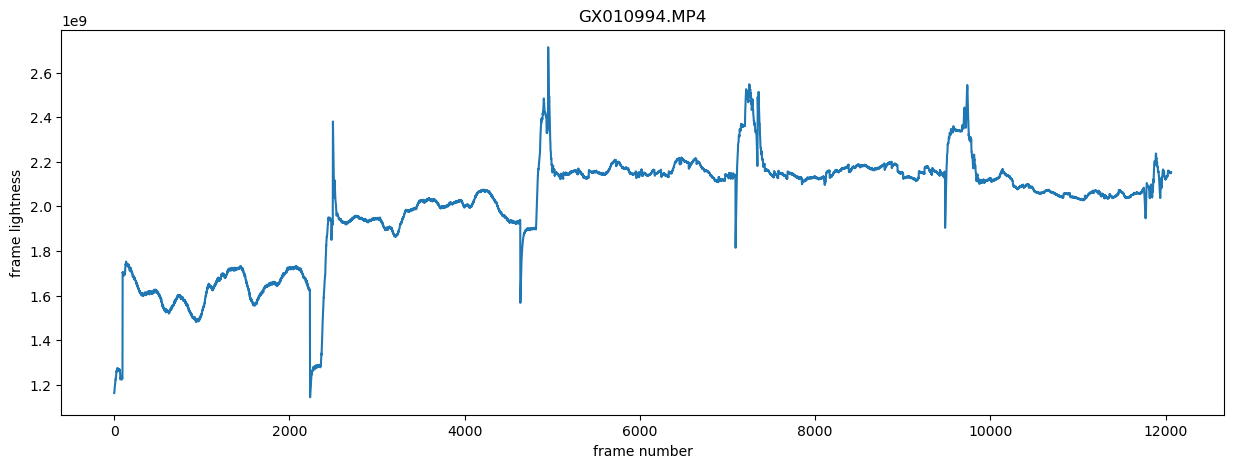

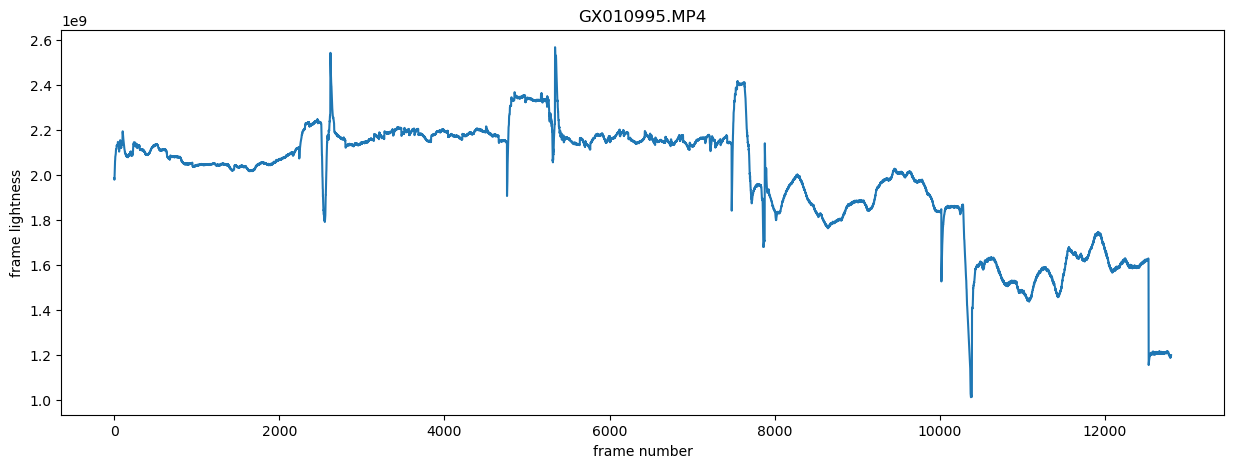

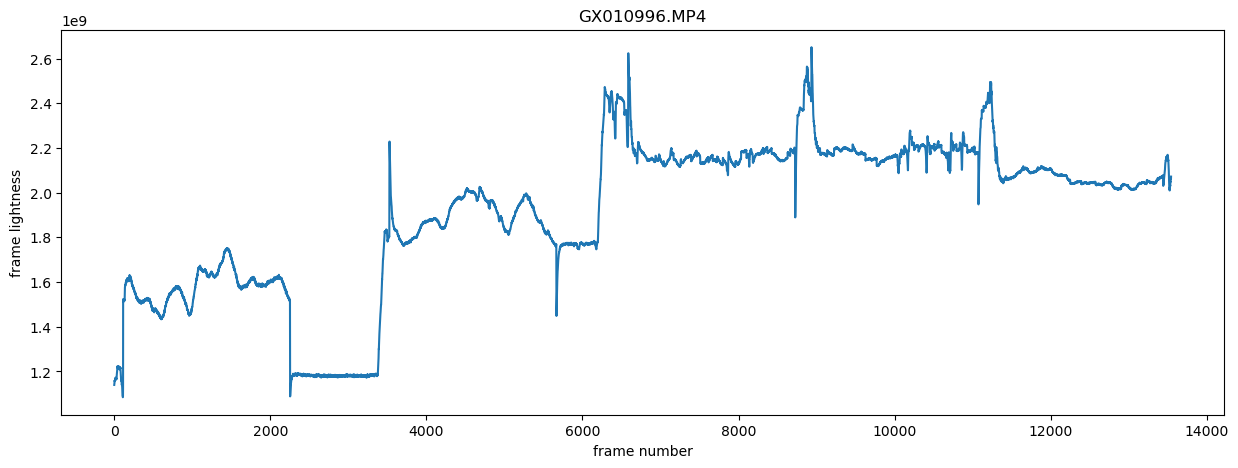

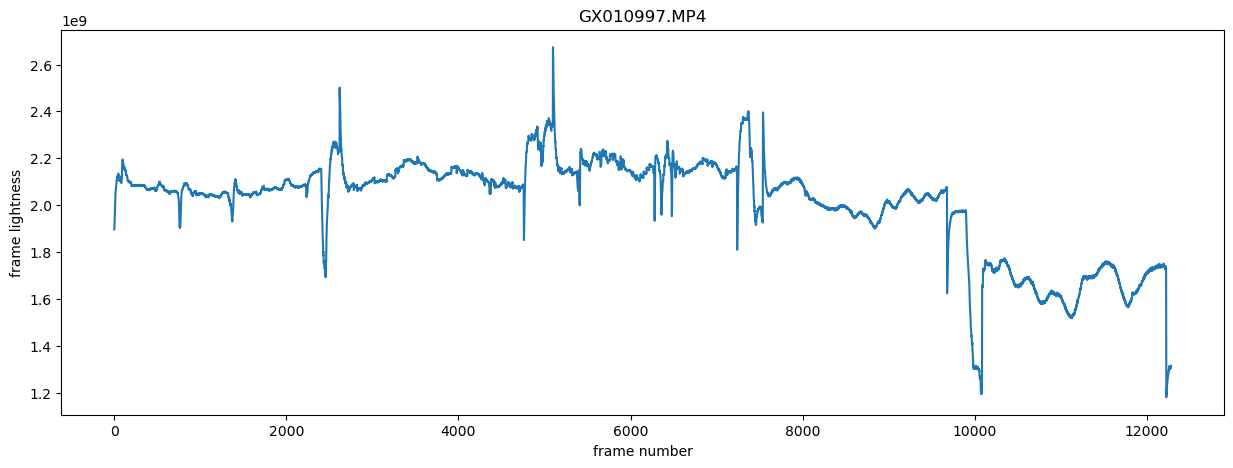

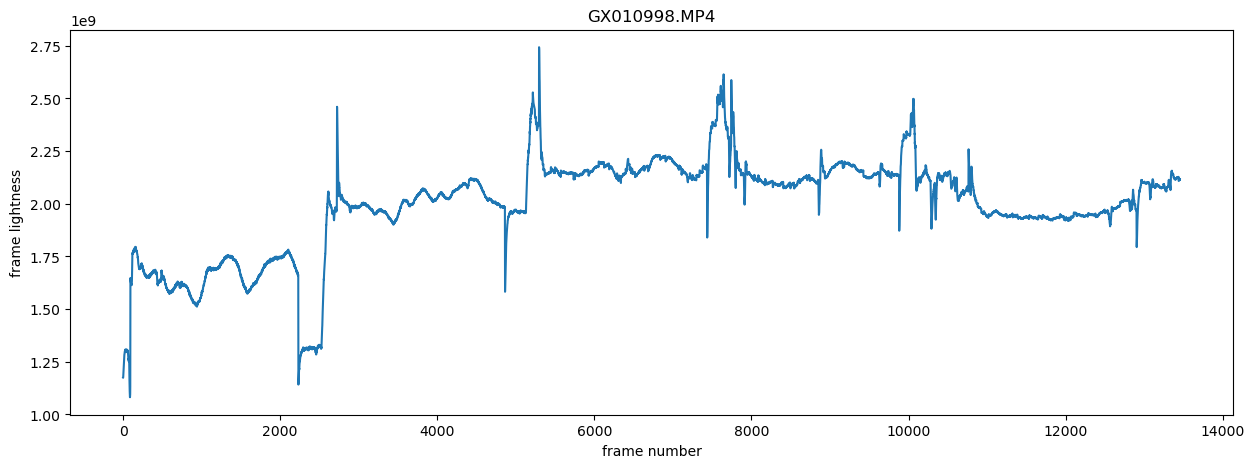

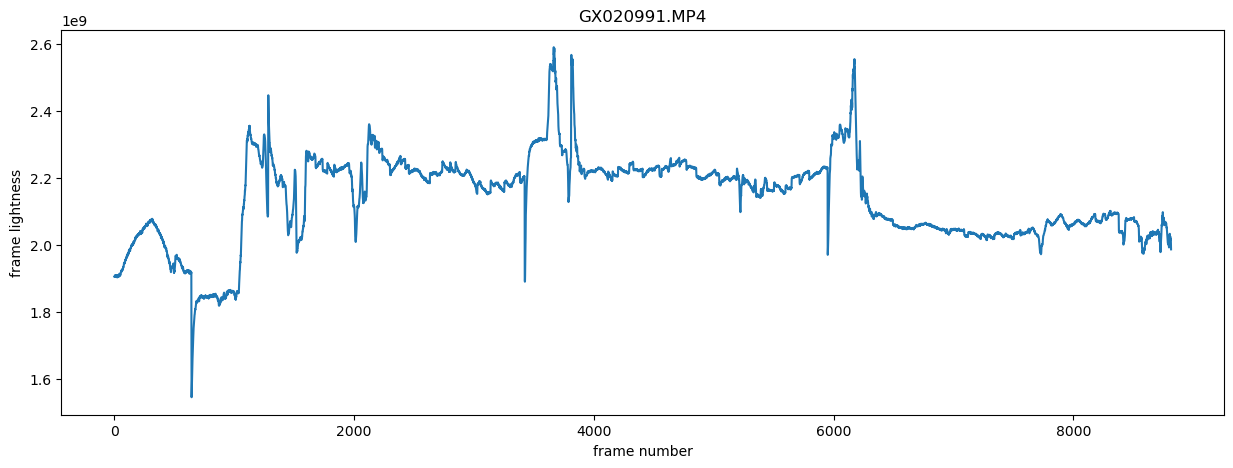

In [23]:
for video, frame_light in zip(videos, frame_lights):
    plt.figure(figsize=(15,5))
    plt.plot(frame_light)
    plt.ylabel("frame lightness")
    plt.xlabel("frame number")
    plt.title(f"{video}")
    plt.show()

In [24]:
from scipy.signal import find_peaks

In [25]:
light_ons = []
light_offs = []

for video, frame_light in zip(videos, frame_lights):
    light_on = find_peaks(np.array(frame_light), distance=2000)
    # light_on = find_peaks(frame_light, distance=2000, height=2*(np.max(frame_light) - np.min(frame_light))/3 + np.min(frame_light))
    light_ons.append(light_on[0])
    light_off = find_peaks(-np.array(frame_light), distance=2000)
    # light_off = find_peaks(-frame_light, distance=2000, height=2*(np.max(-frame_light) - np.min(-frame_light))/3 + np.min(-frame_light))
    light_offs.append(light_off[0])

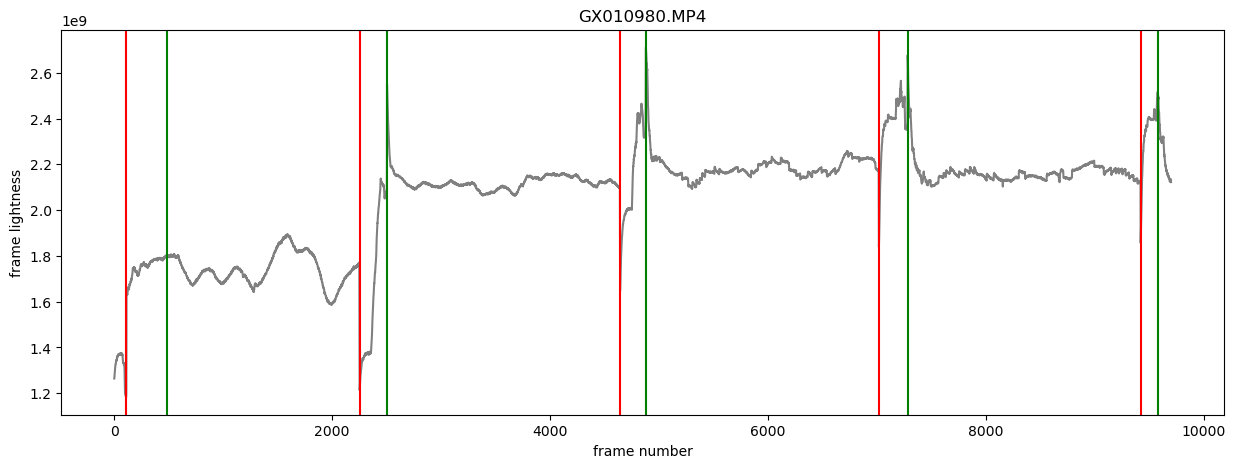

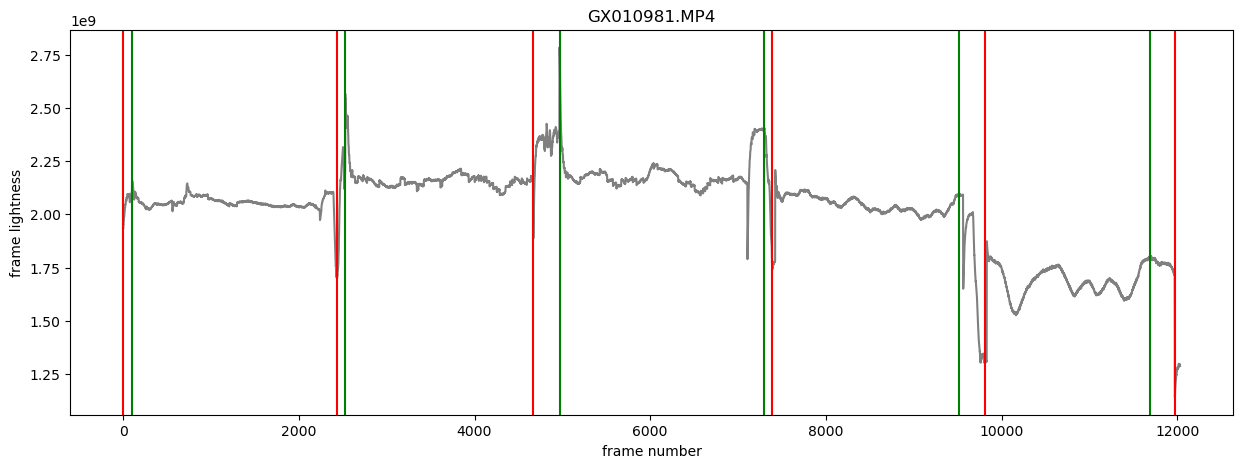

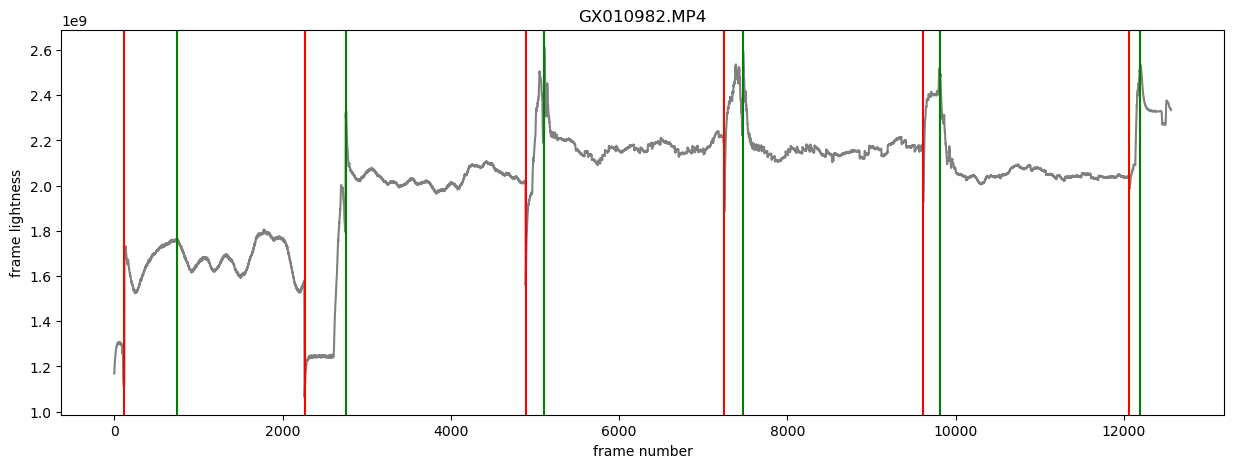

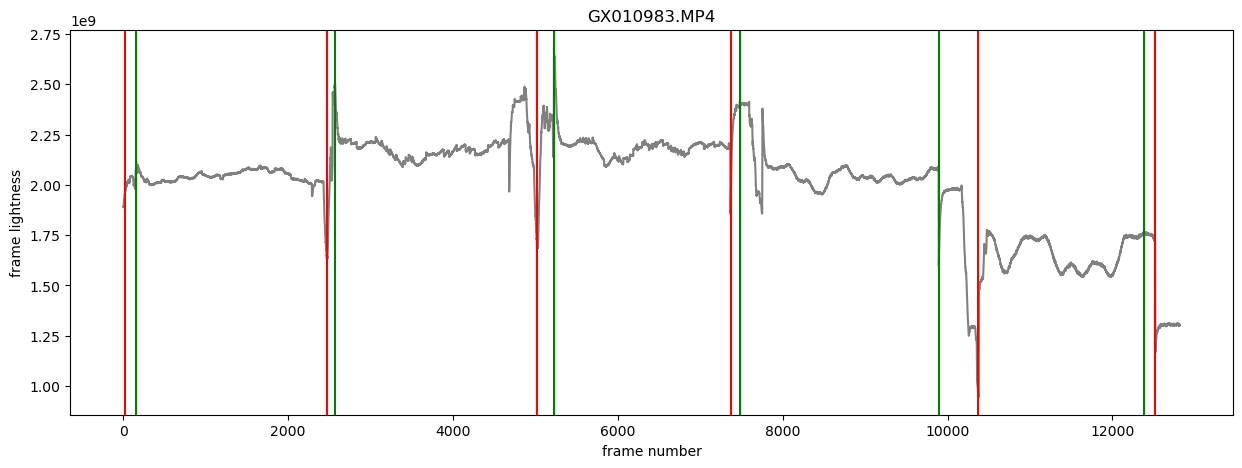

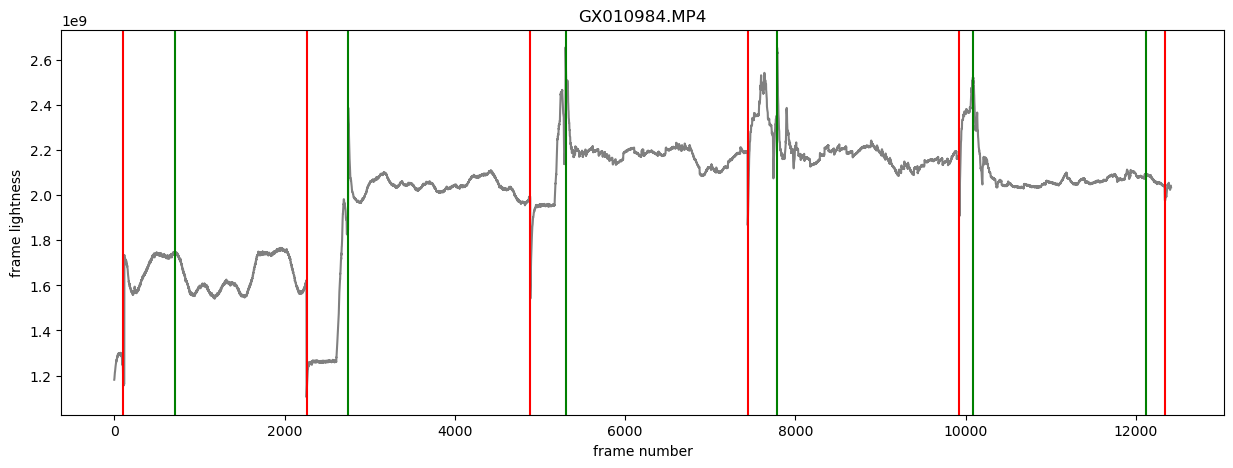

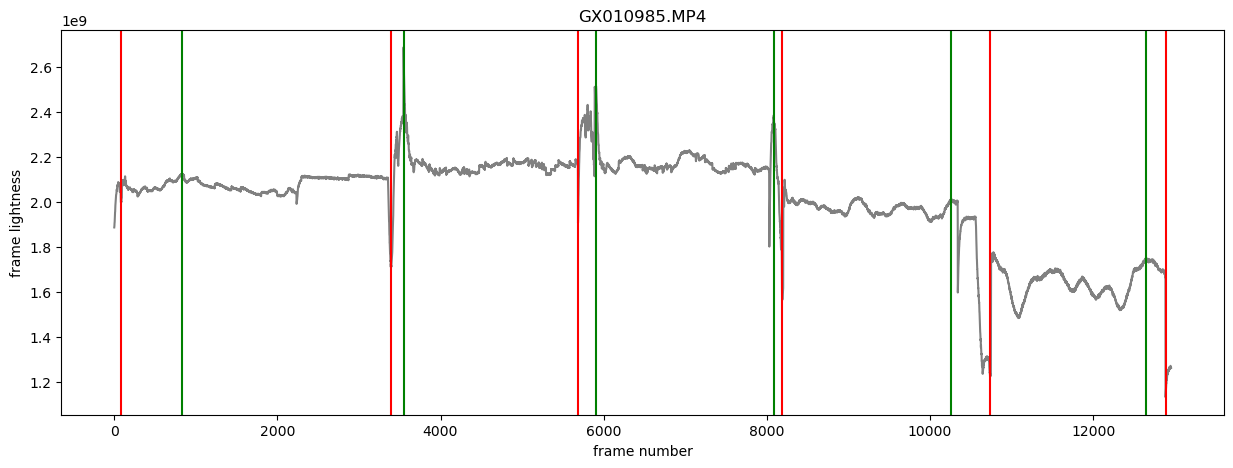

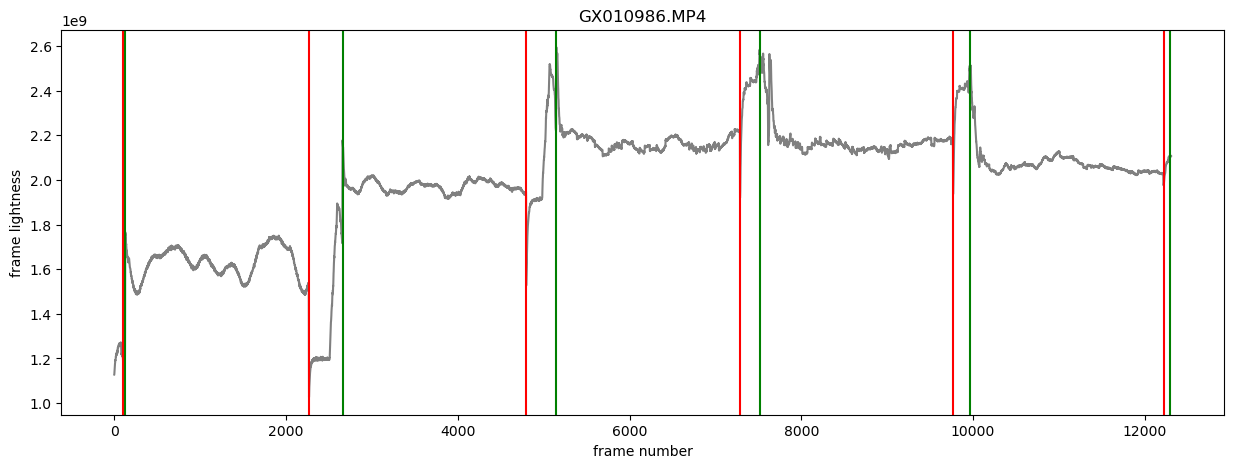

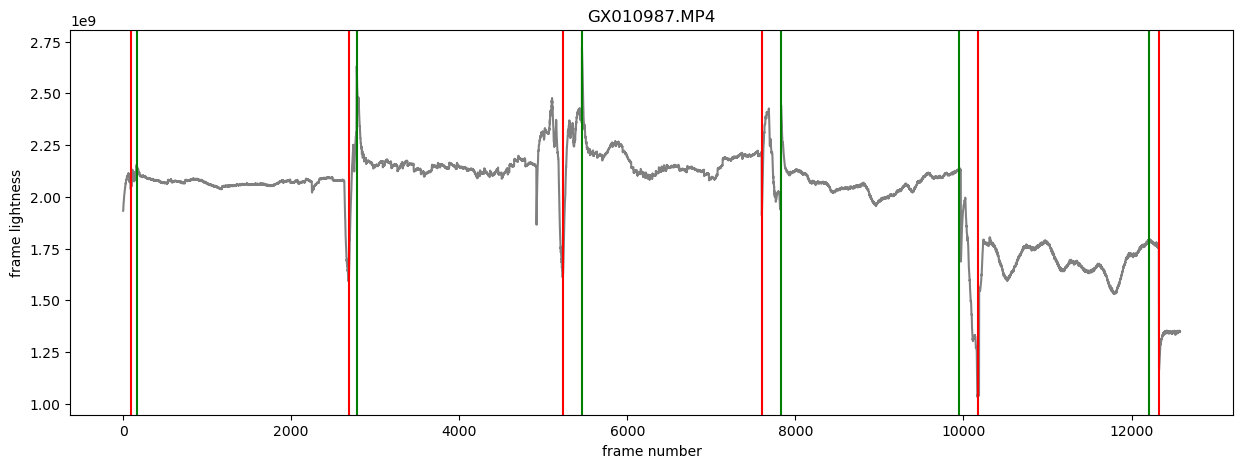

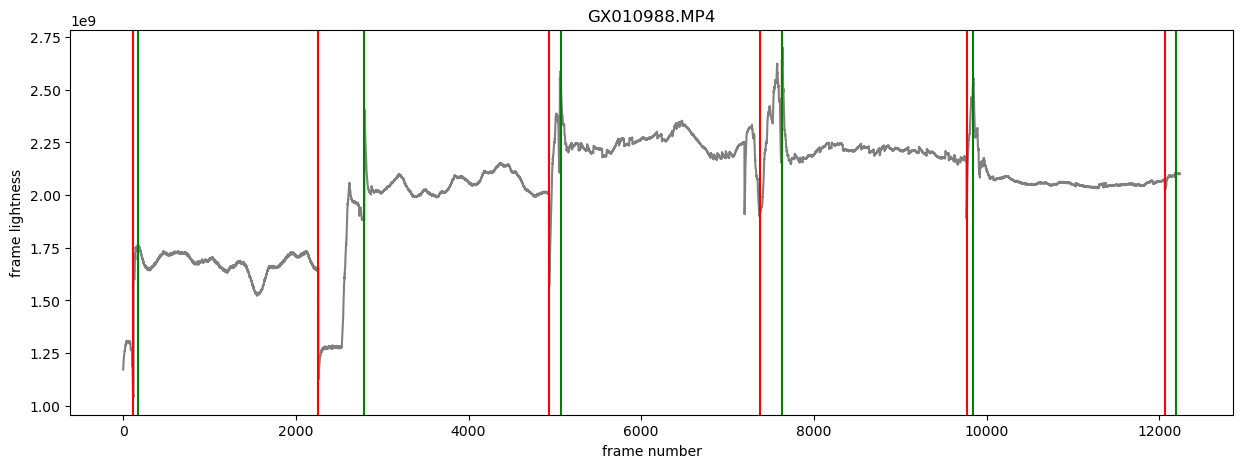

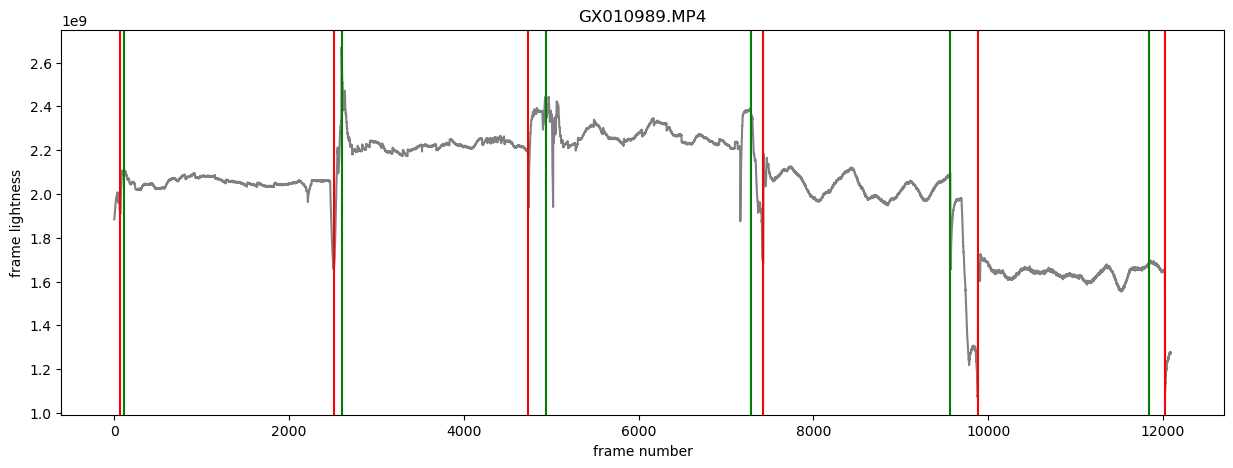

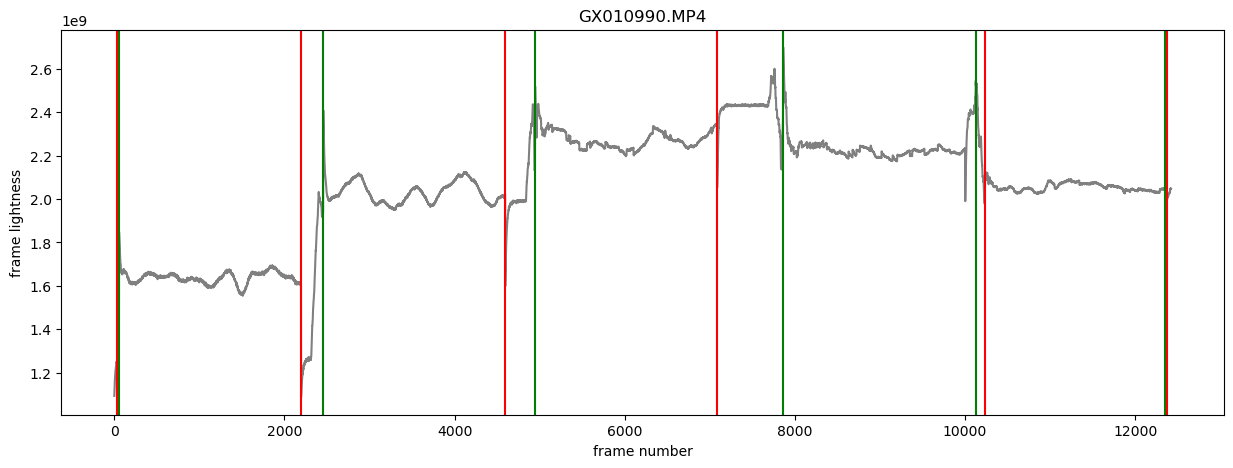

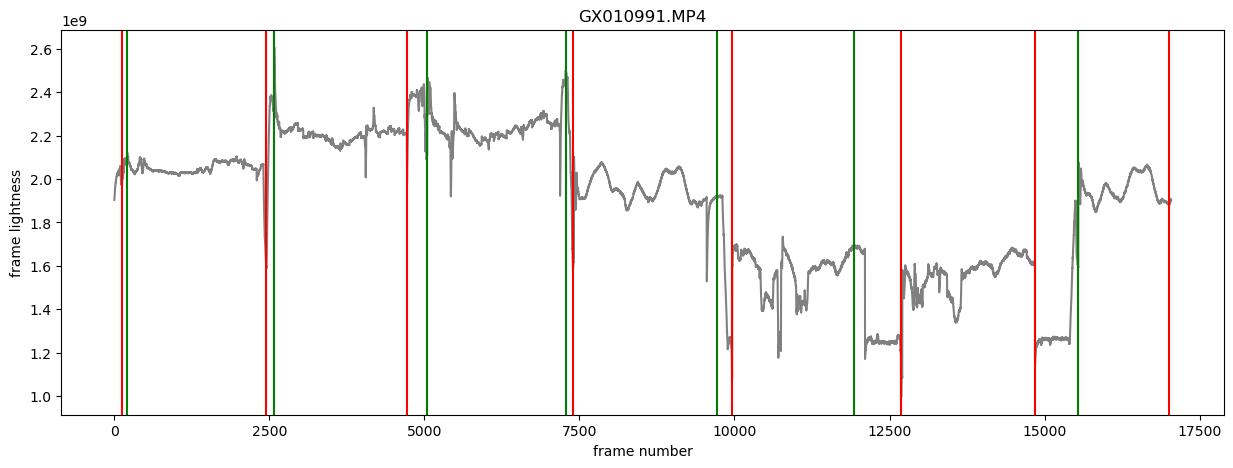

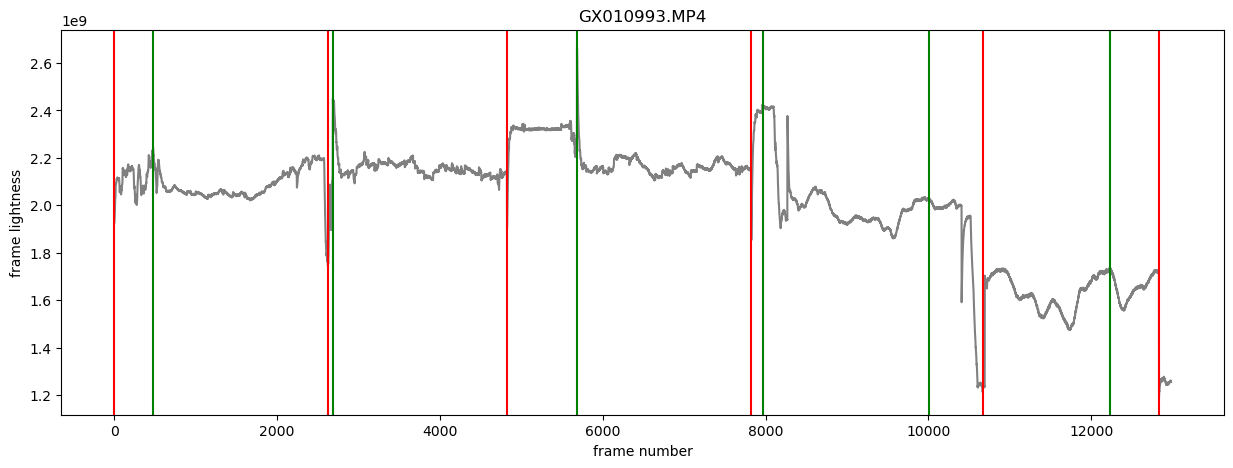

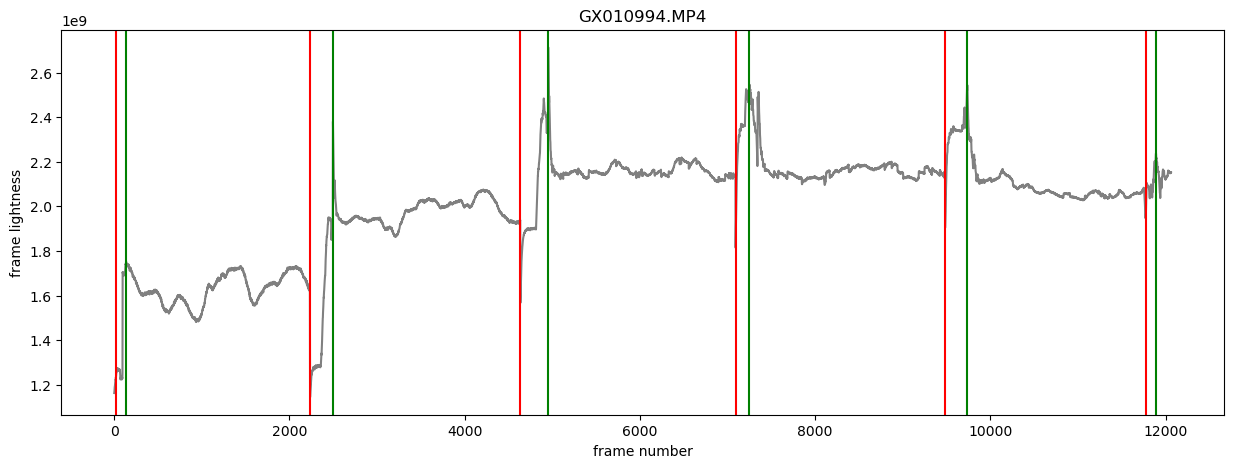

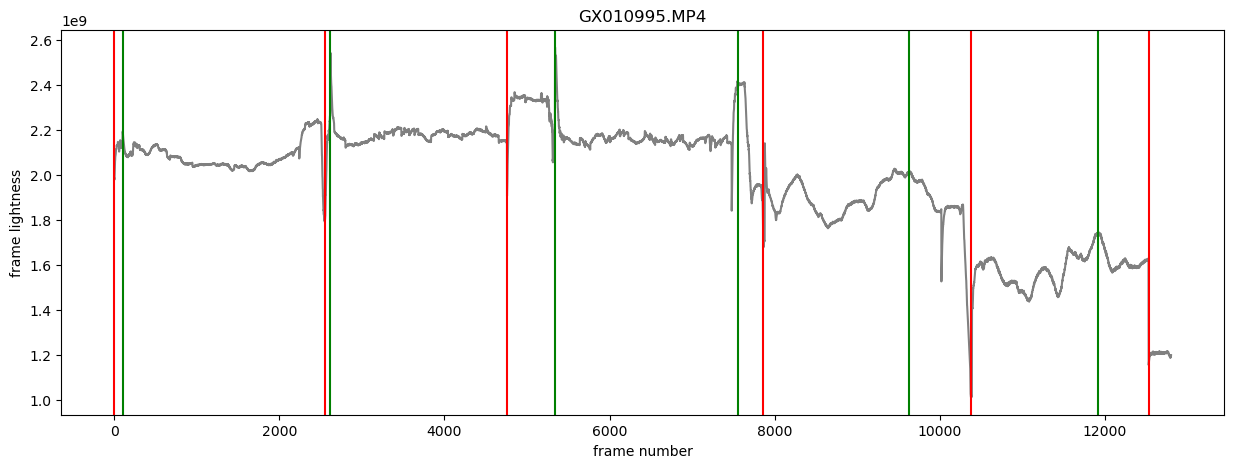

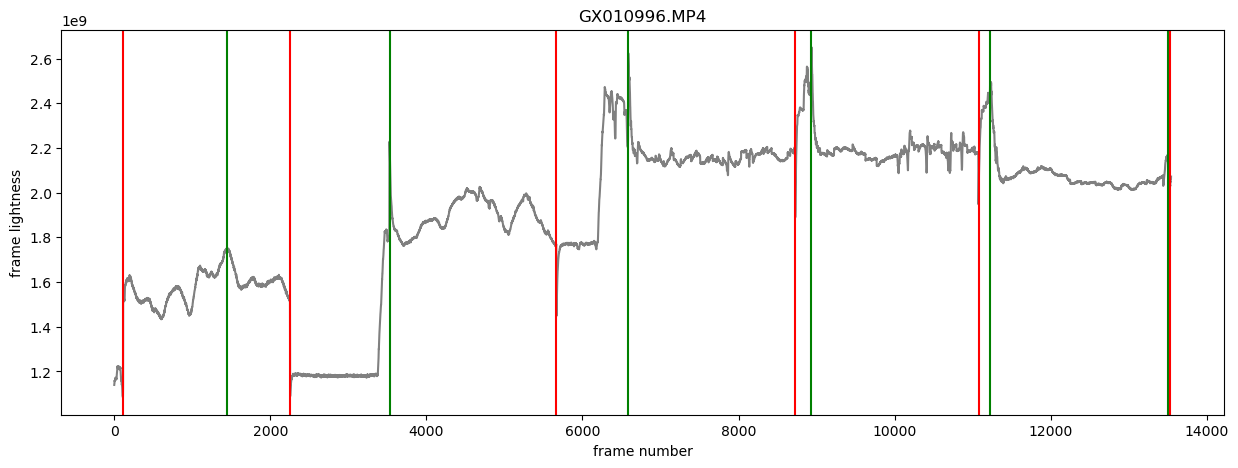

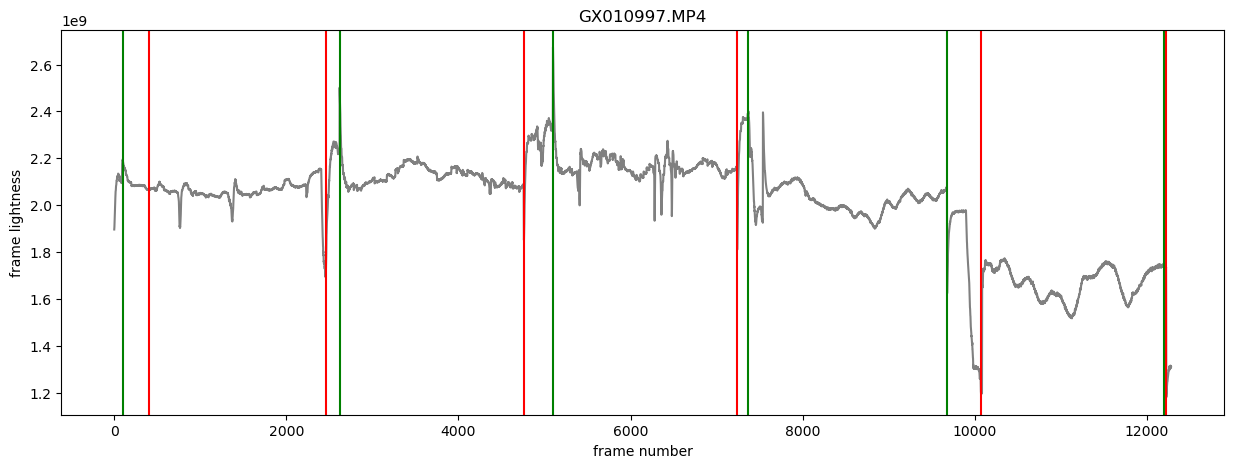

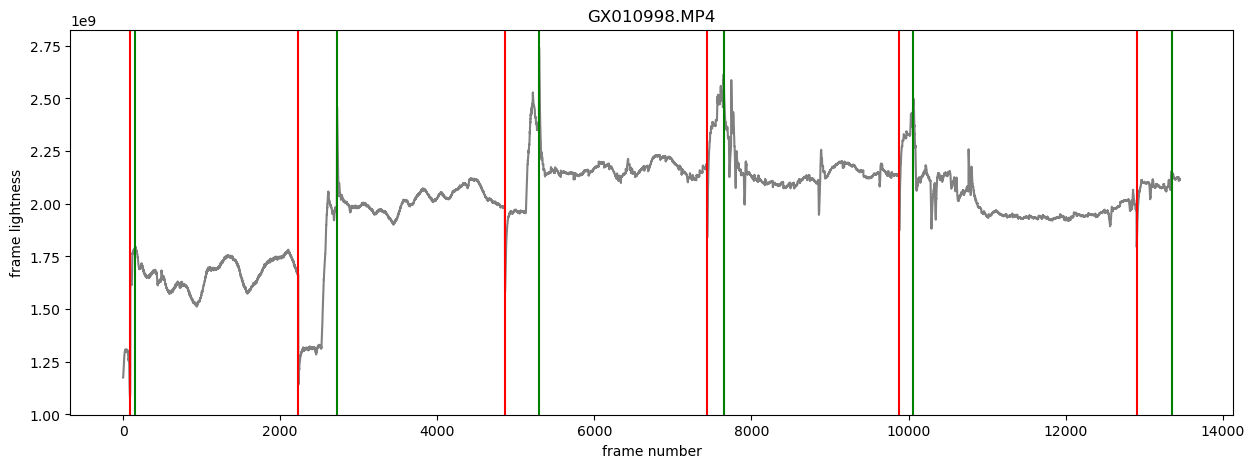

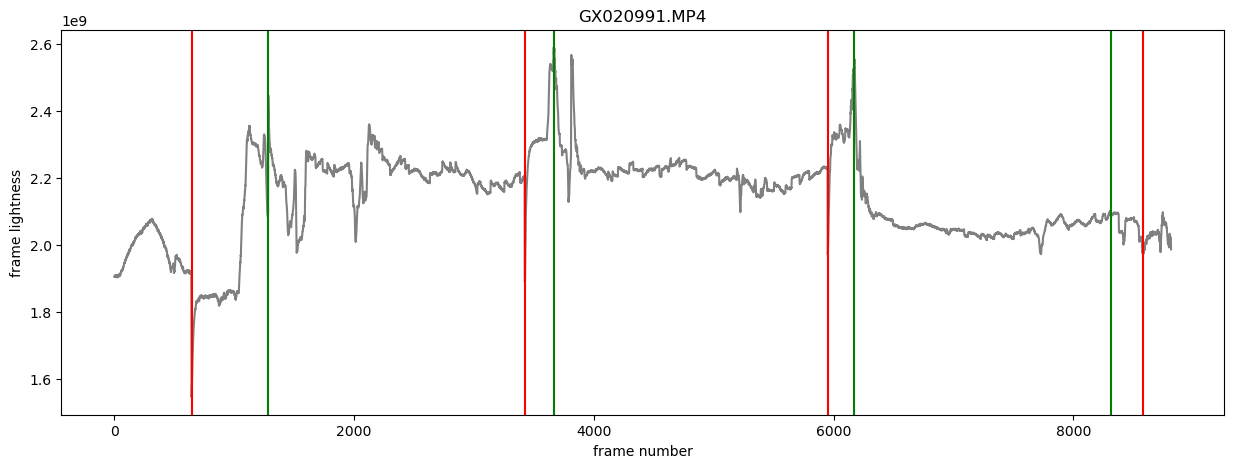

In [26]:
for video, frame_light, light_on, light_off in zip(videos, frame_lights, light_ons, light_offs):
    plt.figure(figsize=(15,5))
    plt.plot(frame_light, color="gray")
    for ons in light_on:
        plt.axvline(ons, color="green")
    for offs in light_off:
        plt.axvline(offs, color="red")    
    plt.ylabel("frame lightness")
    plt.xlabel("frame number")
    plt.title(f"{video}")
    plt.show()

## Motion direction

In [6]:
def getCorners(gray_frame, **feature_params):
    corners = cv2.goodFeaturesToTrack(gray_frame, **feature_params)
    return corners

feature_params = dict(maxCorners=100,
                      qualityLevel=0.1,
                      minDistance=7,
                      blockSize=7)

lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

err_threshold = 9

In [7]:
motion_directions = []

for video in videos:
    file_path = os.path.join(SRC, video.replace(".MP4", "-motion_direction.npy"))
    if not os.path.isfile(file_path):
        motion_direction = []
        vidcap = cv2.VideoCapture(os.path.join(SRC, video))
        
        ret, old_frame = vidcap.read()
        width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH) / 8)
        height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT) / 8)
        old_gray = cv2.cvtColor(cv2.resize(old_frame, (width, height)), cv2.COLOR_BGR2GRAY)
        
        total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        pbar = tqdm(total=total_frames, desc=f"Extraction motion direction for {video}")
        
        while True:
            ret, frame = vidcap.read()
            if not ret:
                break
            frame_gray = cv2.cvtColor(cv2.resize(frame, (width, height)), cv2.COLOR_BGR2GRAY)
            corners = getCorners(old_gray, **feature_params)
        
            if corners is not None:
                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, corners, None, **lk_params)
        
                st = (st == 1) & (err < err_threshold)
                good_new = p1[st == 1]
                good_old = corners[st == 1]
        
                movement_direction = np.mean(good_new - good_old, axis=0)
                max_pos = np.argmax(np.abs(movement_direction))
        
                if max_pos == 0:
                    if movement_direction[max_pos] > 0:
                        motion_direction.append(1)
                    else:
                        motion_direction.append(2)
                else:
                    if movement_direction[max_pos] > 0:
                        motion_direction.append(3)
                    else:
                        motion_direction.append(4)
            else:
                motion_direction.append(0)
        
            old_gray = frame_gray
        
            pbar.update(1)
            
        vidcap.release()
        np.save(file_path, motion_direction)
    motion_directions.append(np.load(file_path))

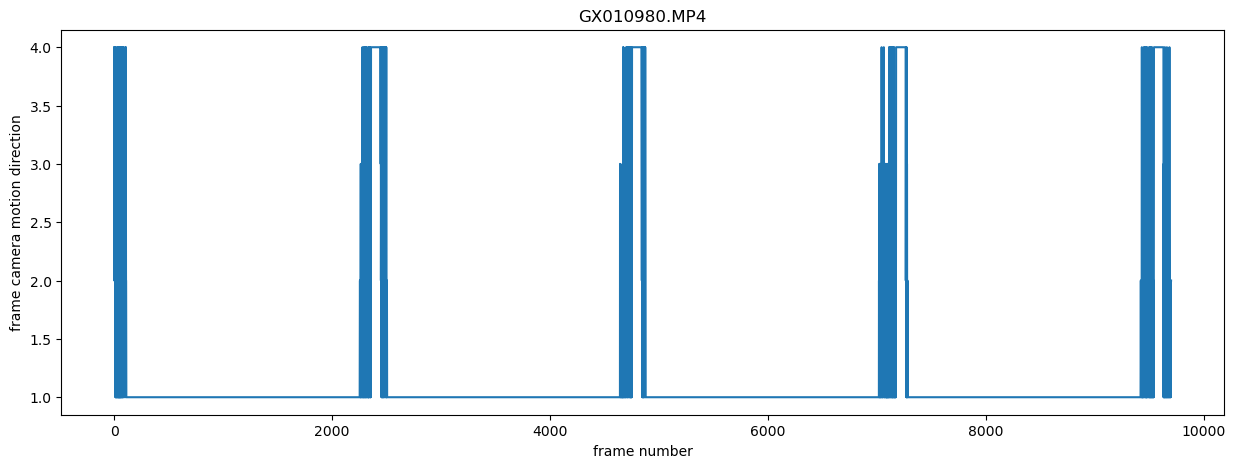

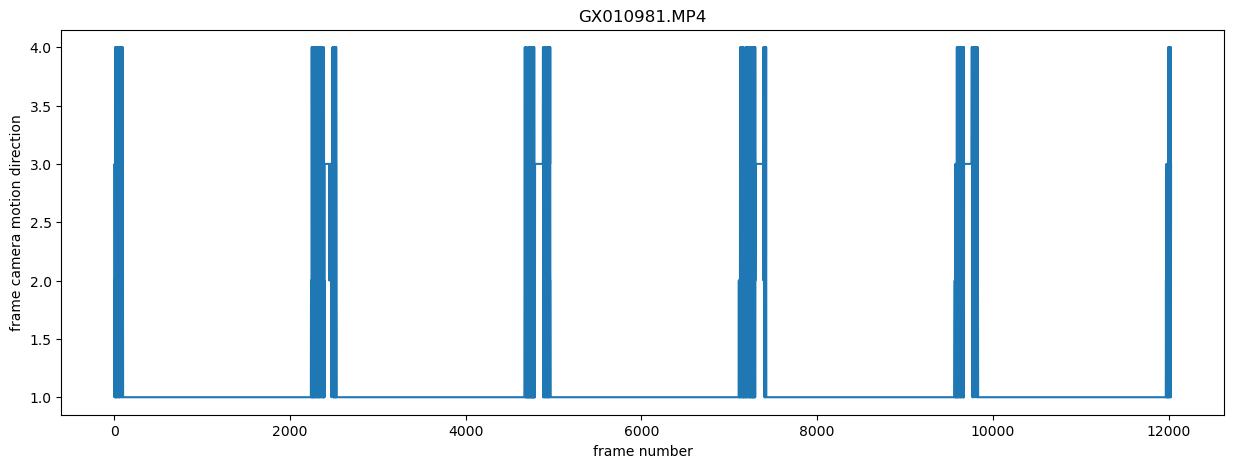

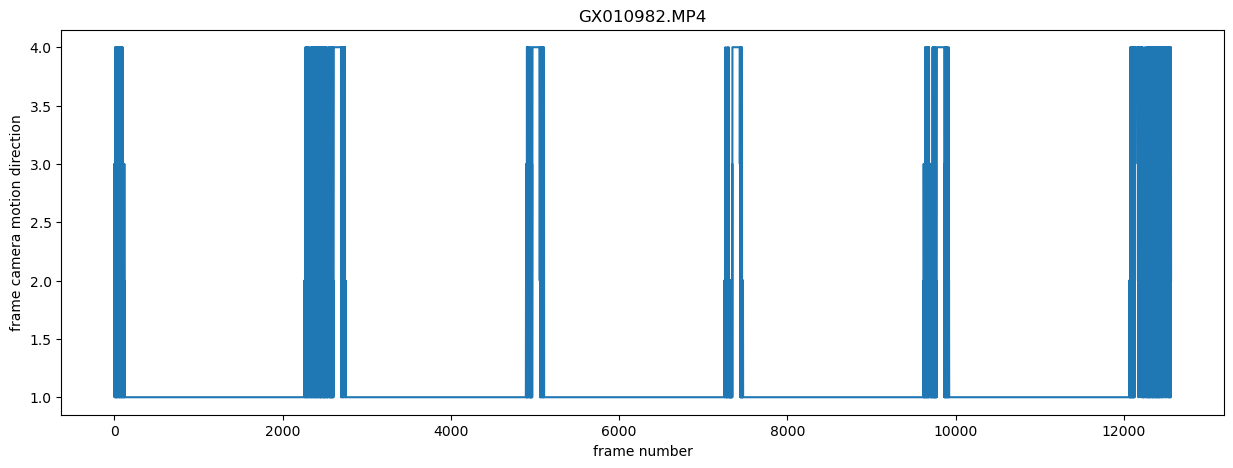

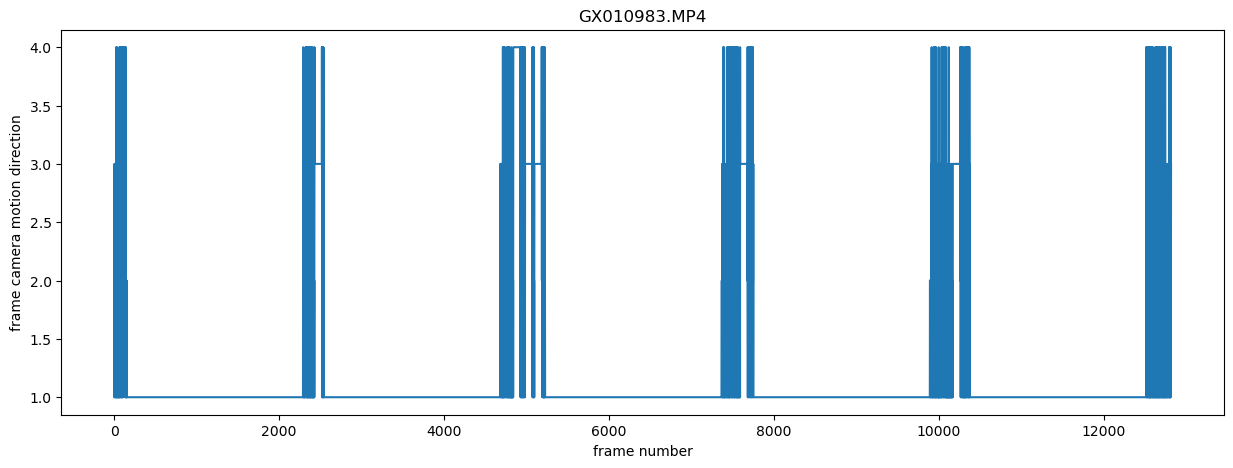

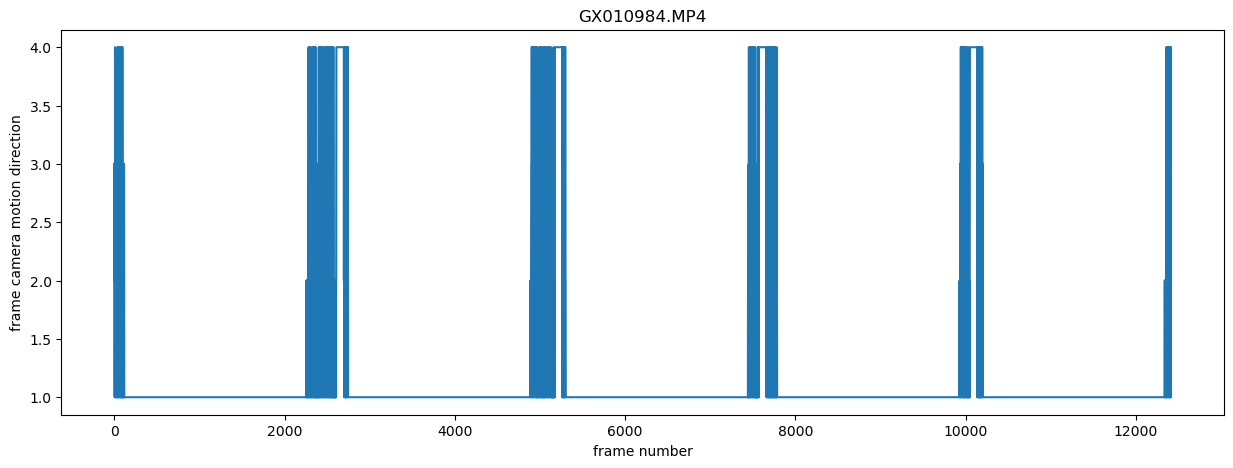

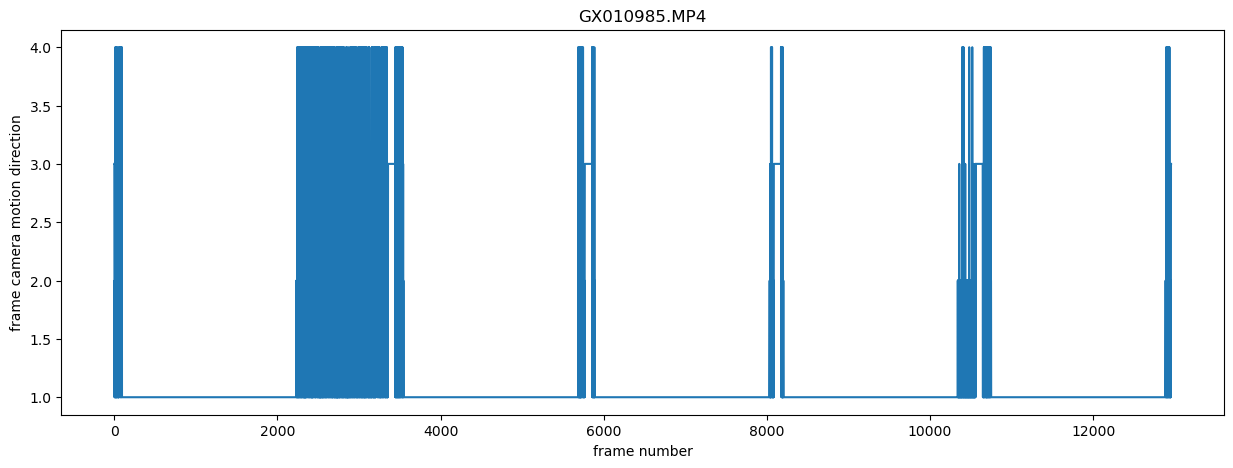

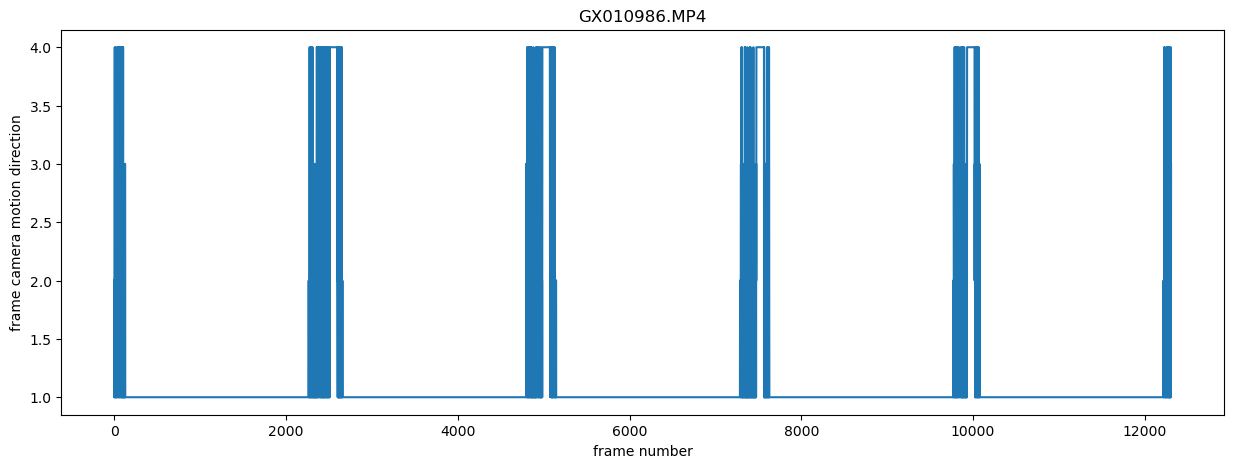

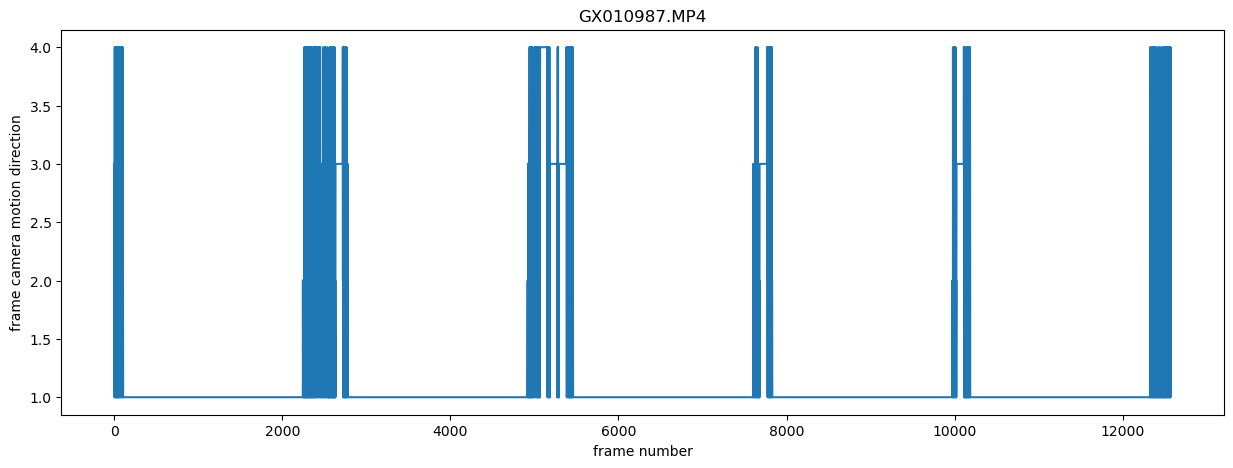

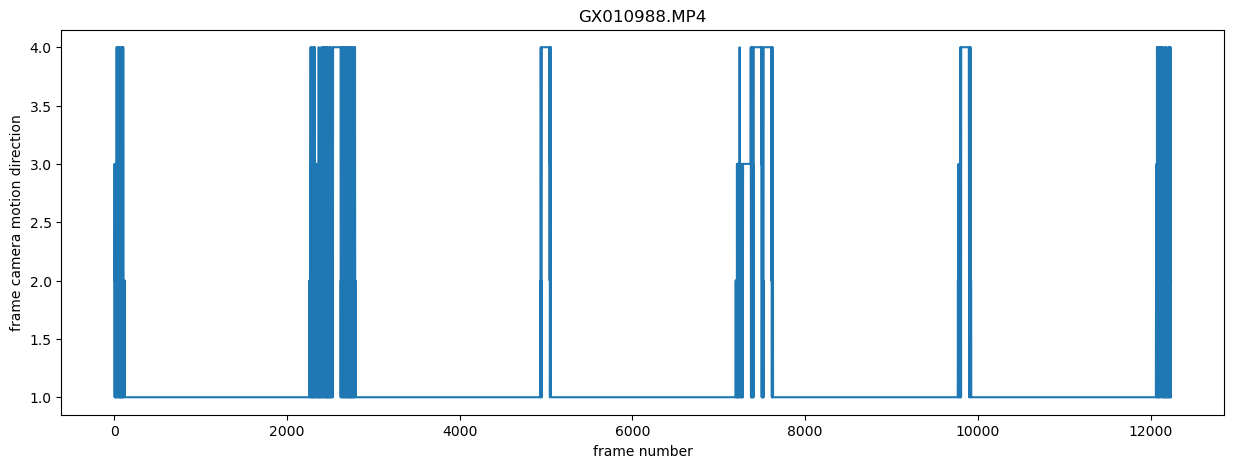

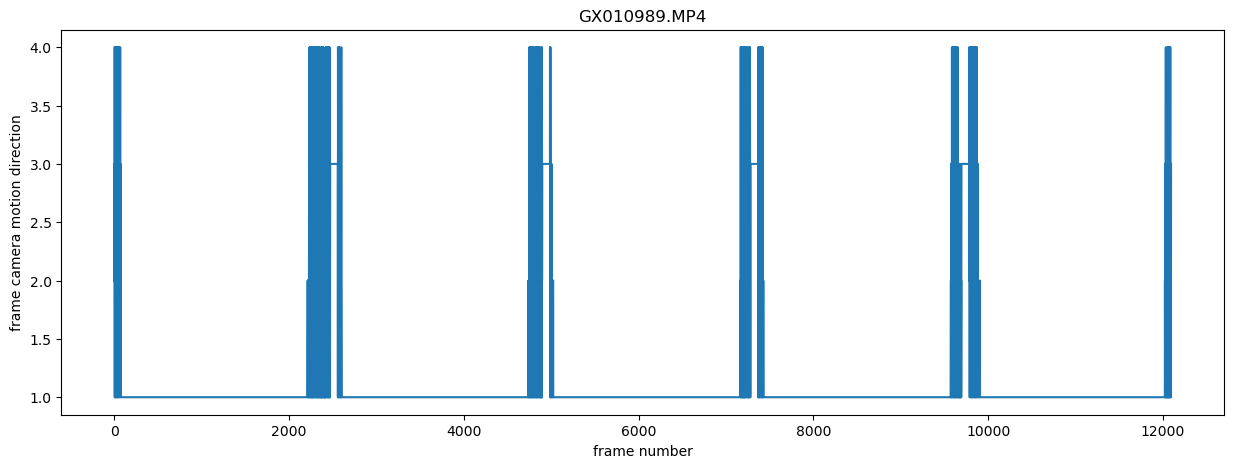

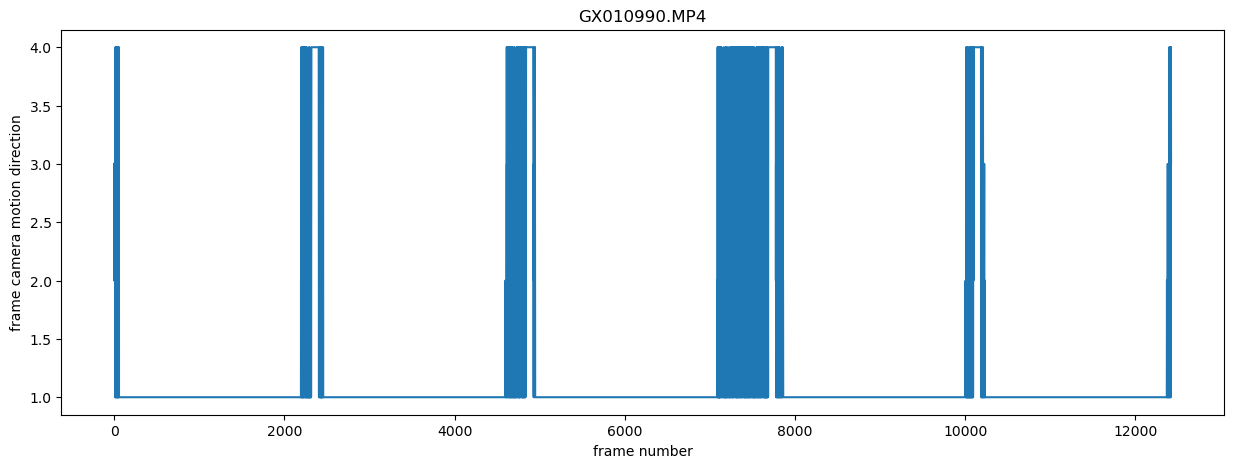

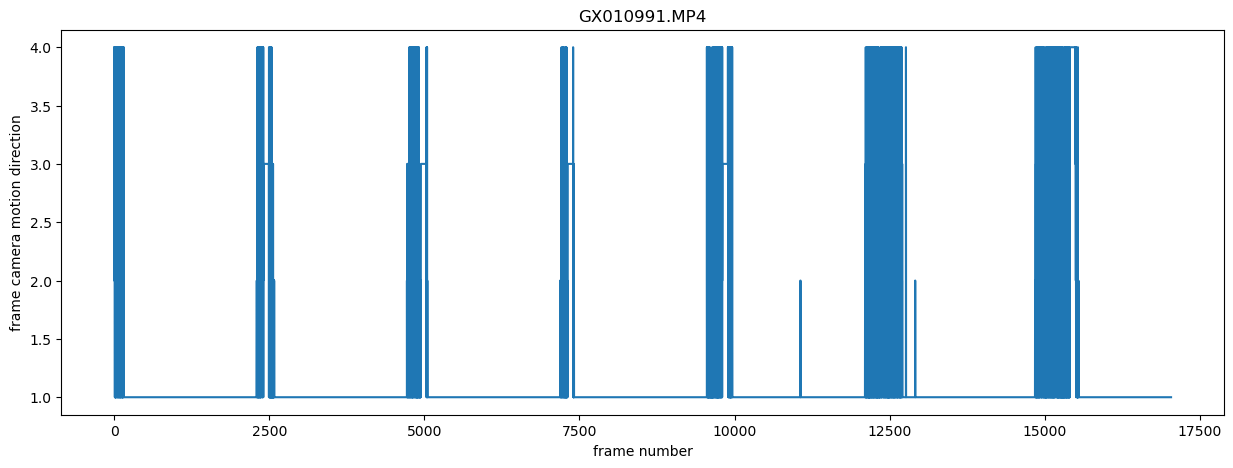

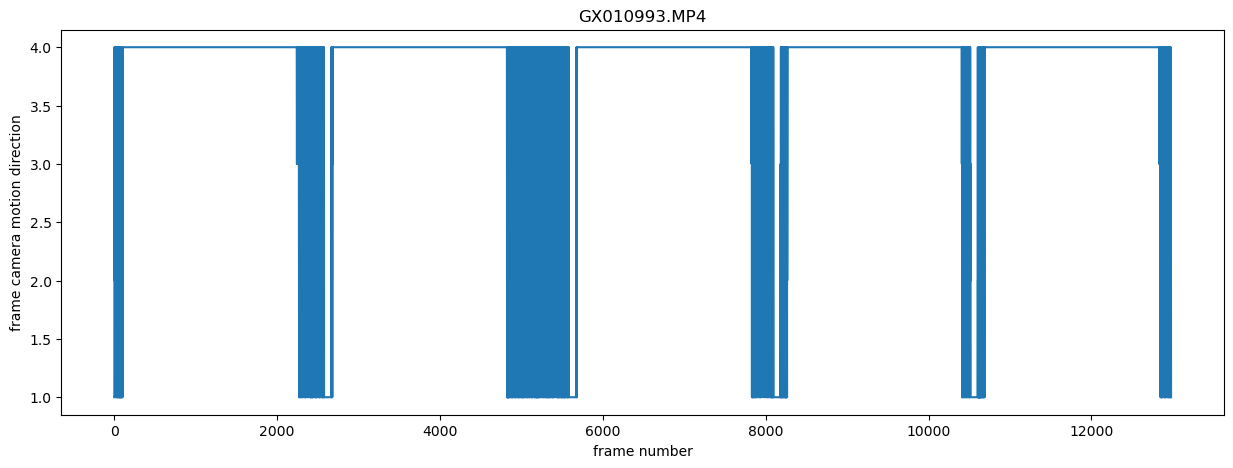

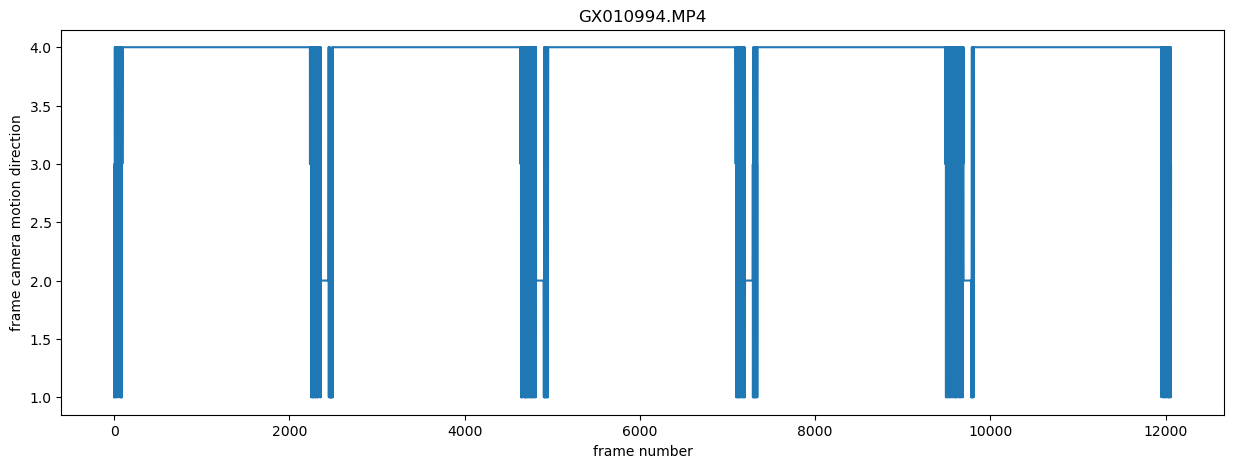

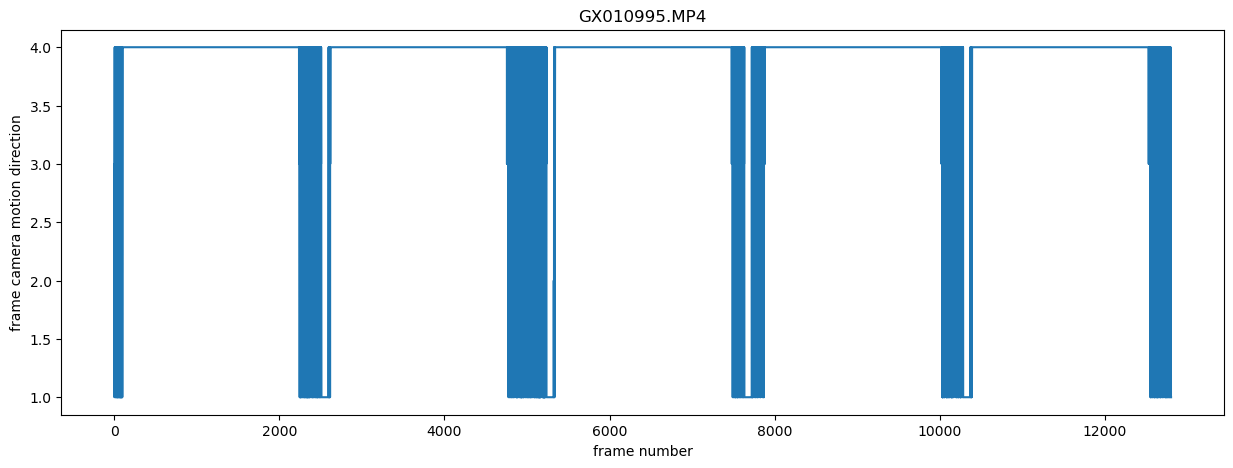

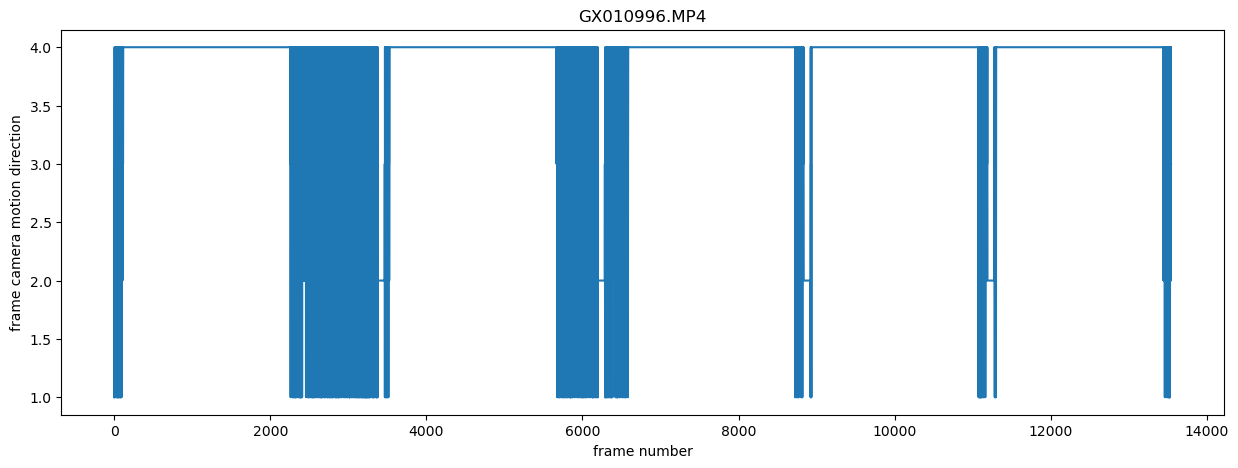

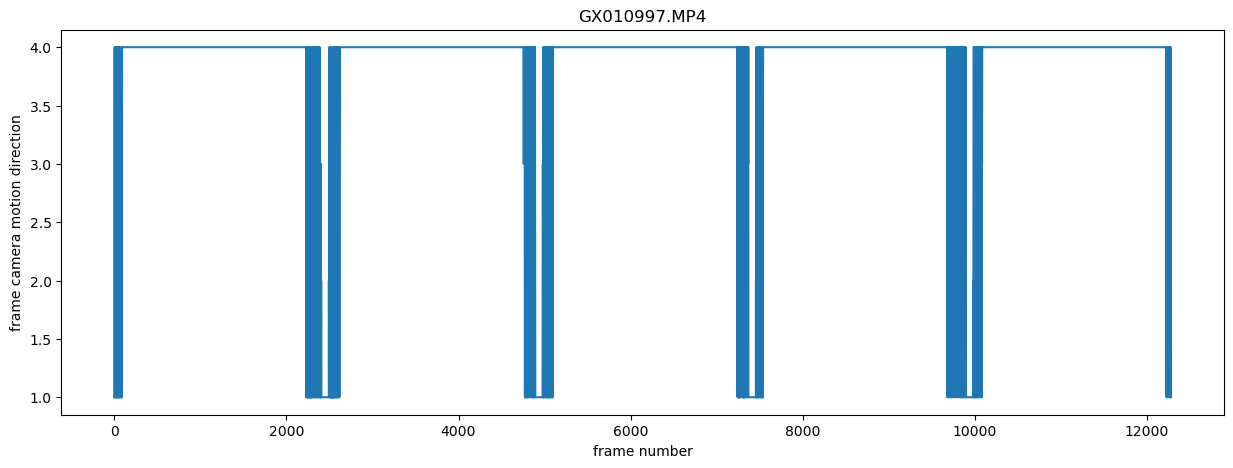

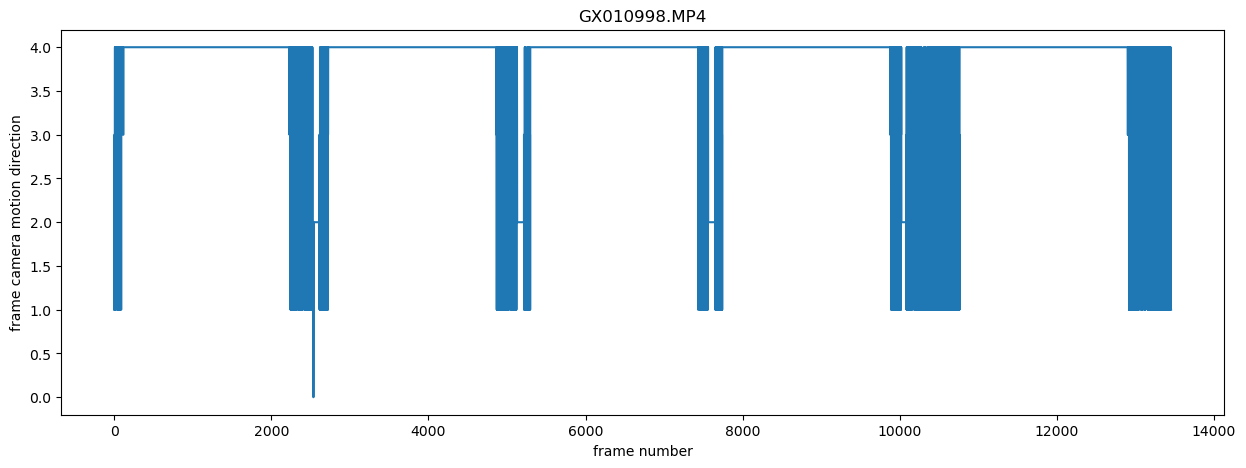

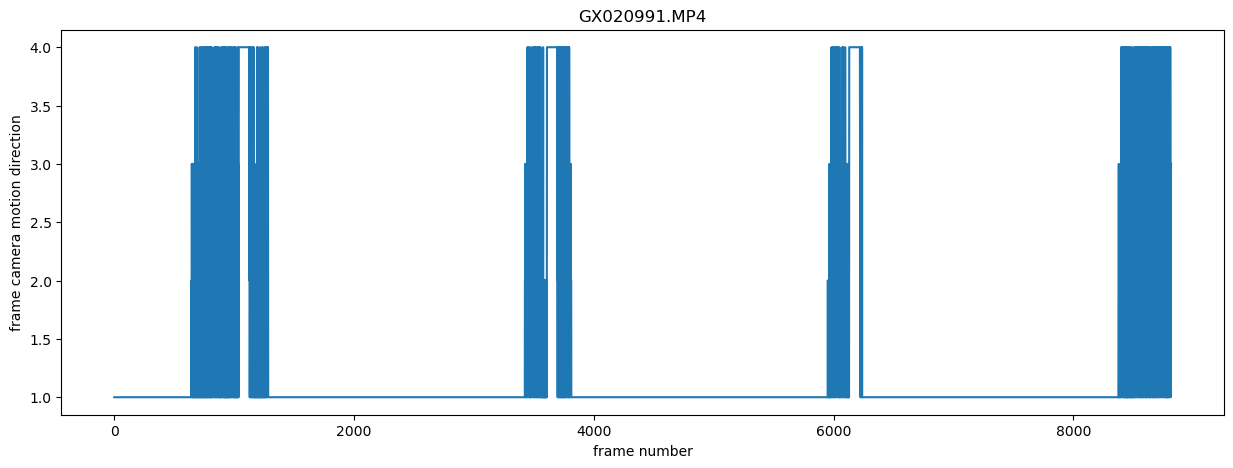

In [29]:
for video, motion_direction in zip(videos, motion_directions):
    plt.figure(figsize=(15,5))
    plt.plot(motion_direction)
    plt.ylabel("frame camera motion direction")
    plt.xlabel("frame number")
    plt.title(f"{video}")
    plt.show()

In [8]:
def getCommonDirection(motion_direction):
    return stats.mode(motion_direction)

In [9]:
def getIntervals(motion_direction):
    desired_movement = getCommonDirection(motion_direction)[0]
    interval = []
    start = 0
    
    for i in range(1, len(motion_direction)):
        if motion_direction[i] != motion_direction[start]:
            if i - start > 10 and motion_direction[start] == desired_movement:
                interval.append((start, i - 1))
            start = i
    
    if len(motion_direction) - 1 - start > 10 and motion_direction[start] == desired_movement:
        interval.append((start, len(motion_direction) - 1))
    
    return interval

In [10]:
def mergeIntervals(interval):
    merged_interval = [interval[0]]
    for i in range(1, len(interval)):
        prev_end = merged_interval[-1][1]
        curr_start, curr_end = interval[i]
    
        if curr_start - prev_end - 1 <= 120:
            merged_interval[-1] = (merged_interval[-1][0], curr_end)
        else:
            merged_interval.append(interval[i])
            
    return merged_interval

In [11]:
intervals = []

for video, motion_direction in zip(videos, motion_directions):
    file_path = os.path.join(SRC, video.replace(".MP4", "-intervals.npy"))
    if not os.path.isfile(file_path):
        interval = getIntervals(motion_direction)
        interval = mergeIntervals(interval)
        np.save(file_path, interval)
    intervals.append(np.load(file_path))

In [12]:
intervals

[array([[ 110, 2253],
        [2504, 4642],
        [4878, 7019],
        [7282, 9421]]),
 array([[  100,  2238],
        [ 2528,  4670],
        [ 4967,  7107],
        [ 7422,  9564],
        [ 9832, 11969]]),
 array([[  121,  2258],
        [ 2749,  4892],
        [ 5109,  7248],
        [ 7473,  9615],
        [ 9922, 12061]]),
 array([[  150,  2289],
        [ 2541,  4682],
        [ 5225,  7367],
        [ 7752,  9892],
        [10377, 12517]]),
 array([[  117,  2257],
        [ 2746,  4885],
        [ 5300,  7441],
        [ 7784,  9925],
        [10197, 12336]]),
 array([[   94,  2232],
        [ 3544,  5685],
        [ 5889,  8032],
        [ 8201, 10339],
        [10748, 12885]]),
 array([[  127,  2264],
        [ 2656,  4796],
        [ 5145,  7285],
        [ 7627,  9767],
        [10076, 12214]]),
 array([[  105,  2244],
        [ 2777,  4917],
        [ 5459,  7602],
        [ 7829,  9972],
        [10185, 12324]]),
 array([[  120,  2259],
        [ 2794,  4933],
        

## Estimate  speed in pixels

### Manually

In [11]:
video = videos[-1]

In [12]:
video

'srp_GX010027_preprocessed.mp4'

In [13]:
vidcap = cv2.VideoCapture(os.path.join(SRC, video))

In [14]:
frame = 260
frame_shift = 120

In [15]:
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
_, a = vidcap.read()
_, a1 = vidcap.read()
# a = cv2.rotate(a, cv2.ROTATE_90_CLOCKWISE)
# a1 = cv2.rotate(a1, cv2.ROTATE_90_CLOCKWISE)
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame + frame_shift // 2)
_, b = vidcap.read()
# b = cv2.rotate(b, cv2.ROTATE_90_CLOCKWISE)
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame + frame_shift)
_, c = vidcap.read()
# c = cv2.rotate(c, cv2.ROTATE_90_CLOCKWISE)

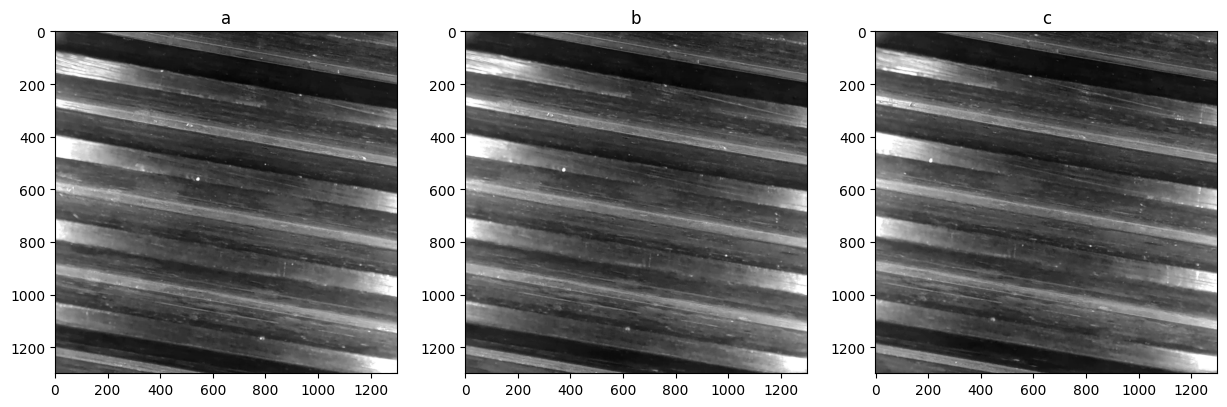

In [16]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
ax.imshow(a[:, :,0], cmap="gray")
ax.set_title("a")
ax = plt.subplot(132)
ax.imshow(b[:, :,0], cmap="gray")
ax.set_title("b")
ax = plt.subplot(133)
ax.imshow(c[:,:,0], cmap="gray")
ax.set_title("c")
plt.show()

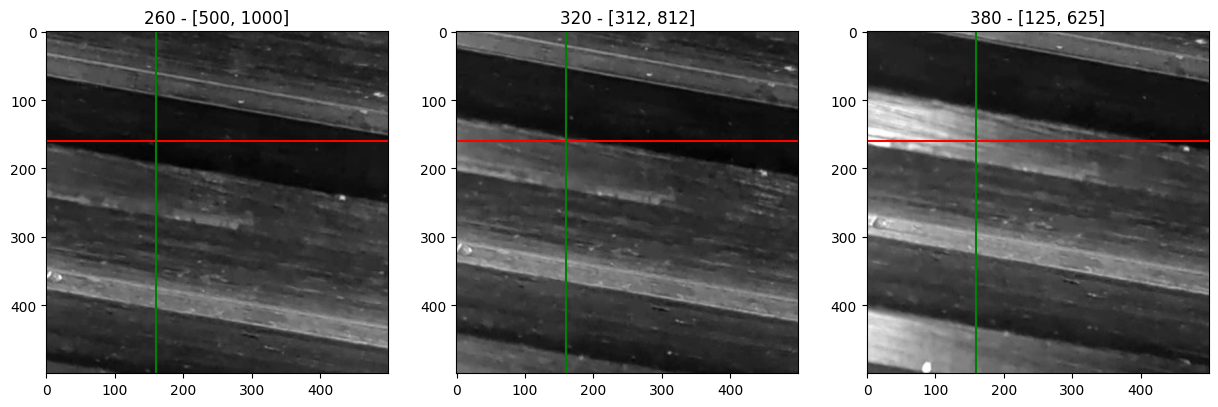

In [23]:
crop_shift = -375
feature_shift = 0

x = 500
y = 500
f = 160

plt.figure(figsize=(15,5))
ax = plt.subplot(131)
ax.imshow(a[:y, x:x+500,0], cmap="gray")
ax.axhline(f, color="red")
ax.axvline(f, color="green")
ax.set_title(f"{frame} - [{x}, {x + 500}]")
ax = plt.subplot(133)
ax.imshow(c[:y,x + crop_shift + feature_shift:x + crop_shift + feature_shift + 500, 0], cmap="gray")
ax.axhline(f, color="red")
ax.axvline(f, color="green")
ax.set_title(f"{frame + frame_shift} - [{x+crop_shift + feature_shift}, {x + crop_shift + 500 + feature_shift}]")
ax = plt.subplot(132)
ax.imshow(b[:y,x+crop_shift // 2 + feature_shift // 2:x + crop_shift // 2 + 500 + feature_shift // 2,0], cmap="gray")
ax.axhline(f, color="red")
ax.axvline(f, color="green")
ax.set_title(f"{frame + frame_shift // 2} - [{x+crop_shift // 2 + feature_shift // 2}, {x + crop_shift // 2 + 500 + feature_shift // 2}]")
plt.show()

Posun spočtu jako:
- `frame_shift` počet framů posunu => 120
- `crop_shift` posun výřezu => 1600
- `feature_shift` počet pixelů posunu stejné featury => 74

  ```∆ = (crop_shift + feature_shift) / frame_shift```

In [24]:
shift_per_frame = (crop_shift + feature_shift) / frame_shift

In [25]:
shift_per_frame

-3.125

### Automatically

In [37]:
# csv is calculated in 01_relative_position_per_frame_csv.ipynb

In [38]:
csvs = [file for file in os.listdir(SRC) if file.endswith("intervals-errfilter.csv") and file.startswith(video.removesuffix('.MP4'))]

In [39]:
csvs

['GX010998-4-0.1-20-3-8-intervals-errfilter.csv',
 'GX010998-4-0.1-7-7-9-intervals-errfilter.csv',
 'GX010998-4-0.3-7-7-999-intervals-errfilter.csv',
 'GX010998-5-0.1-20-3-8-intervals-errfilter.csv',
 'GX010998-5-0.1-7-7-9-intervals-errfilter.csv',
 'GX010998-5-0.3-7-7-999-intervals-errfilter.csv',
 'GX010998-6-0.1-20-3-8-intervals-errfilter.csv',
 'GX010998-6-0.1-7-7-9-intervals-errfilter.csv',
 'GX010998-6-0.3-7-7-999-intervals-errfilter.csv']

In [40]:
csv = csvs[1]

In [41]:
df = pd.read_csv(os.path.join(SRC, csv))
metadata = np.load(os.path.join(SRC, csv).replace('.csv', '.npy'))
df.attrs['video'] = metadata[0]
df.attrs['scale'] = metadata[1]
df.attrs['time'] = metadata[2]
df.attrs['fail_corner_frames'] = metadata[3]
df.attrs['fail_good_frames'] = metadata[4]
df.attrs['landscape'] = metadata[5]
df.attrs['qualityLevel'] = metadata[6]
df.attrs['minDistance'] = metadata[7]
df.attrs['blockSize'] = metadata[8]
df.attrs['errThreshold'] = metadata[9]
df.set_index("frame_ID")

x_shift       y_shift
frame_ID                           
1.0          0.000000      0.000000
2.0          0.000000      0.000000
3.0          0.000000      0.000000
4.0          0.000000      0.000000
5.0          0.000000      0.000000
...               ...           ...
13453.0  -1423.490377 -28195.392417
13454.0  -1423.490377 -28195.392417
13455.0  -1423.490377 -28195.392417
13456.0  -1423.490377 -28195.392417
13457.0  -1423.490377 -28195.392417

[13457 rows x 2 columns]

In [42]:
axis_horizontal = "y_shift"
axis_horizontal_diff = "y_shift_diff"
axis_vertical = "x_shift"
axis_vertical_diff = "x_shift_diff"

In [43]:
df[axis_horizontal_diff] = df[axis_horizontal].diff()
df.loc[0, axis_horizontal_diff] = df[axis_horizontal].iloc[0]
df[axis_vertical_diff] = df[axis_vertical].diff()
df.loc[0, axis_vertical_diff] = df[axis_vertical].iloc[0]

In [44]:
df

frame_ID      x_shift       y_shift  y_shift_diff  x_shift_diff
0           1.0     0.000000      0.000000           0.0           0.0
1           2.0     0.000000      0.000000           0.0           0.0
2           3.0     0.000000      0.000000           0.0           0.0
3           4.0     0.000000      0.000000           0.0           0.0
4           5.0     0.000000      0.000000           0.0           0.0
...         ...          ...           ...           ...           ...
13452   13453.0 -1423.490377 -28195.392417           0.0           0.0
13453   13454.0 -1423.490377 -28195.392417           0.0           0.0
13454   13455.0 -1423.490377 -28195.392417           0.0           0.0
13455   13456.0 -1423.490377 -28195.392417           0.0           0.0
13456   13457.0 -1423.490377 -28195.392417           0.0           0.0

[13457 rows x 5 columns]

In [45]:
def getInvertedIntervals(intervals):
    return np.array([[intervals[i-1][1], intervals[i][0]] for i in range(1, len(intervals))])

In [46]:
intervals_horizontal = np.load(os.path.join(SRC, video).replace(".MP4", "-intervals.npy"))
intervals_vertical = getInvertedIntervals(intervals_horizontal)
mask_horizontal = pd.Series(False, index=df.index)
mask_vertical = pd.Series(False, index=df.index)
for start, end in intervals_horizontal:
    mask_horizontal |= (df['frame_ID'] >= start) & (df['frame_ID'] <= end)
for start, end in intervals_vertical:    
    mask_vertical |= (df['frame_ID'] >= start) & (df['frame_ID'] <= end)

In [47]:
intervals_horizontal, intervals_vertical

(array([[   92,  2229],
        [ 2723,  4865],
        [ 5296,  7433],
        [ 7741,  9880],
        [10763, 12902]]),
 array([[ 2229,  2723],
        [ 4865,  5296],
        [ 7433,  7741],
        [ 9880, 10763]]))

In [48]:
df_horizontal = df[mask_horizontal]
df_vertical = df[mask_vertical]

In [49]:
shift_per_frame = abs(df_horizontal[axis_horizontal_diff].mean()*df.attrs['scale'])

In [50]:
shift_per_frame

10.541318783725796

## Angle speed

### Manually

In [26]:
frame = 80
frame_shift = 2825

vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
_, a = vidcap.read()
# a = cv2.rotate(a, cv2.ROTATE_90_CLOCKWISE)
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame + frame_shift)
_, b = vidcap.read()
# b = cv2.rotate(b, cv2.ROTATE_90_CLOCKWISE)

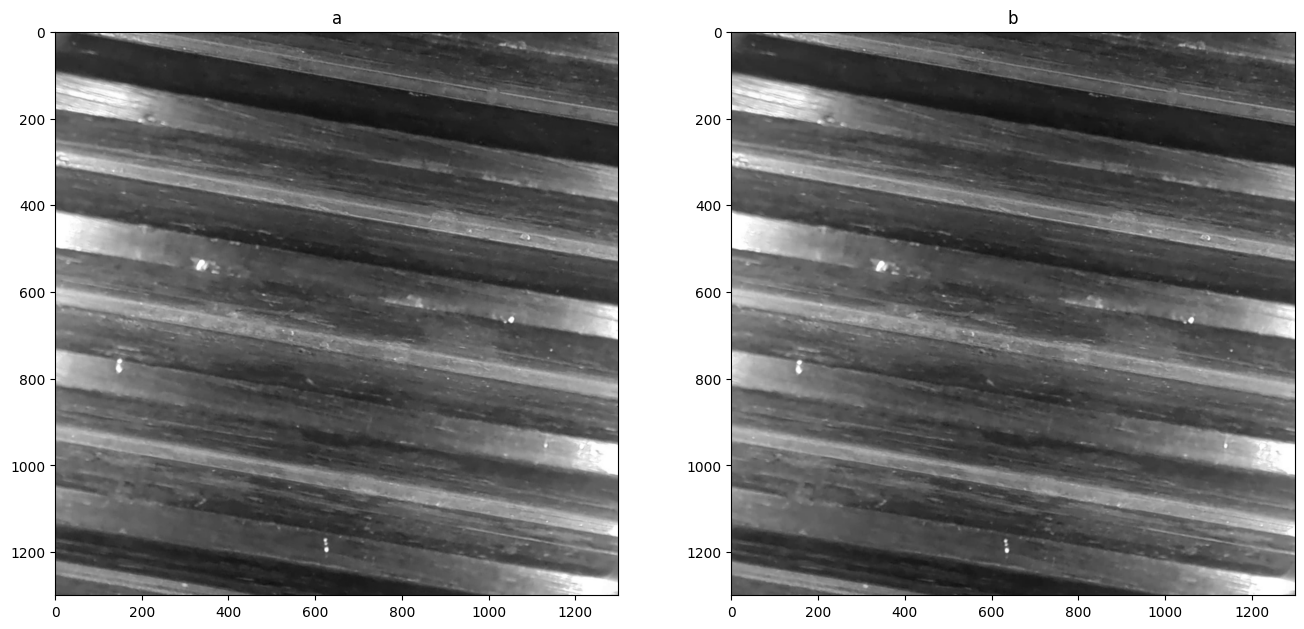

In [27]:
plt.figure(figsize=(16,8))
ax = plt.subplot(121)
ax.imshow(a[:, :], cmap="gray")
ax.set_title("a")
ax = plt.subplot(122)
ax.imshow(b[:, :], cmap="gray")
ax.set_title("b")
plt.show()

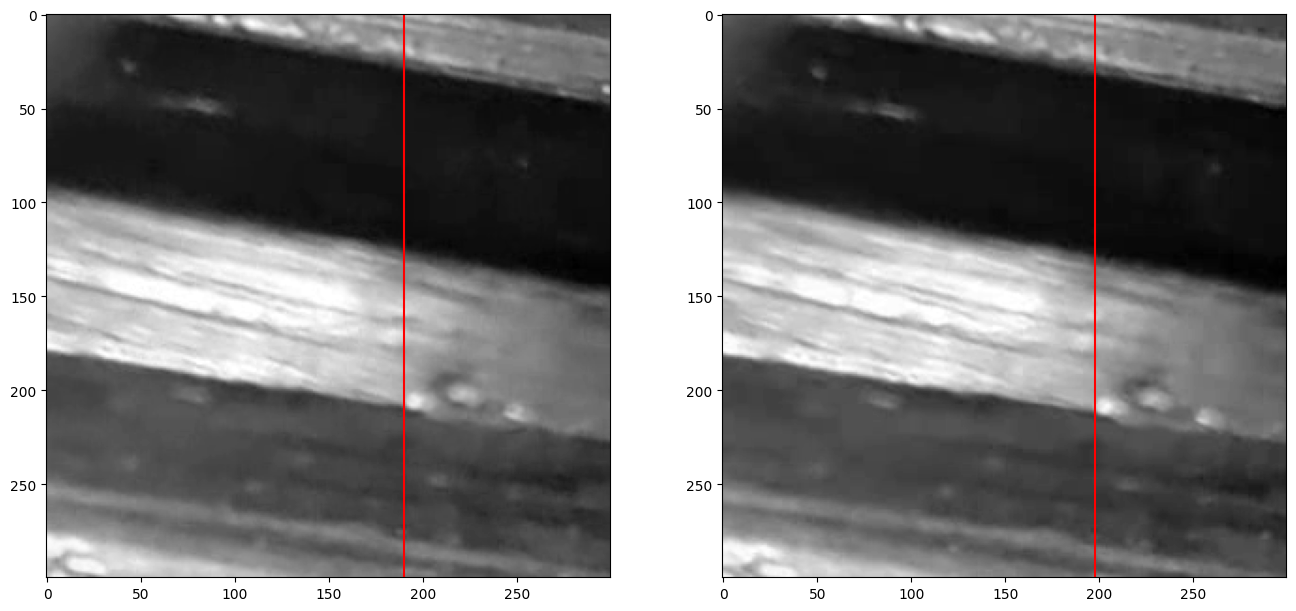

In [33]:
feature_shift = 8

x = 0
y = 500
f = 190

plt.figure(figsize=(16,8))
ax = plt.subplot(121)
ax.imshow(a[:300,x:x+300,0], cmap="gray")
ax.axvline(f, color="red")
ax = plt.subplot(122)
ax.imshow(b[:300,x:x+300,0], cmap="gray")
ax.axvline(f+feature_shift, color="red")
plt.show()

In [34]:
# fps = 1/timings[0][1][1]
fps = 60

In [36]:
shift_per_frame = -3.125

In [37]:
fps, shift_per_frame, frame_shift + feature_shift/shift_per_frame

(60, -3.125, 2822.44)

In [38]:
pixels_per_360 = frame_shift * shift_per_frame + feature_shift
pixels_per_s = shift_per_frame * fps
s_per_360 = pixels_per_360 / pixels_per_s
frames_per_360 = np.ceil(pixels_per_360 / shift_per_frame).astype(int)

In [39]:
pixels_per_360, pixels_per_s, s_per_360, frames_per_360

(-8820.125, -187.5, 47.04066666666667, np.int64(2823))

### Automatically

In [86]:
intervals = [[0., 2989.], [4451., 7438.], [9438., 12424.], [13689., 16673.]]
intervals = np.array(intervals)  # Convert to NumPy array

In [102]:
frame_shift = int(np.ceil(np.mean(intervals[:, 1] - intervals[:, 0]) / 1.057))
frame = intervals[0][0] + 100

In [103]:
frame_shift, frame

(2826, np.float64(100.0))

In [46]:
vidcap = cv2.VideoCapture(os.path.join(SRC, videos[-2]))

In [47]:
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
_, a = vidcap.read()
a = cv2.rotate(a, cv2.ROTATE_90_CLOCKWISE)
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame + frame_shift)
_, b = vidcap.read()
b = cv2.rotate(b, cv2.ROTATE_90_CLOCKWISE)

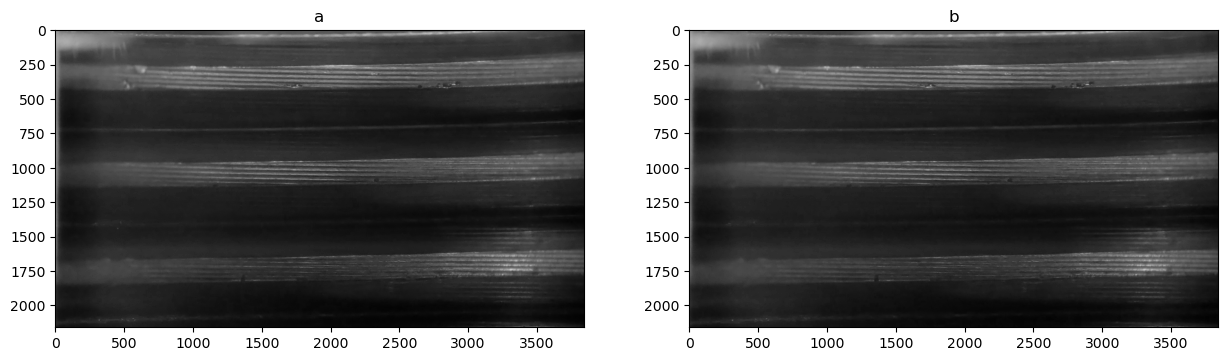

In [48]:
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.imshow(a[:, :,0], cmap="gray")
ax.set_title("a")
ax = plt.subplot(122)
ax.imshow(b[:, :,0], cmap="gray")
ax.set_title("b")
plt.show()

In [49]:
feature_params = dict(maxCorners=100,
                      qualityLevel=0.1,
                      minDistance=7,
                      blockSize=7)

lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

err_threshold = 9

In [50]:
a_gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
b_gray = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(a_gray, **feature_params)

if corners is not None:
    p1, st, err = cv2.calcOpticalFlowPyrLK(a_gray, b_gray, corners, None, **lk_params)

    st = (st == 1) & (err < err_threshold)
    p1 = p1[st == 1]
    p0 = corners[st == 1]
    
    move = np.mean(p1-p0, axis=0)

In [51]:
corners.shape

(91, 1, 2)

In [52]:
err

array([[7.47125  ],
       [5.9466667],
       [7.29125  ],
       [6.8247223],
       [7.1719446],
       [7.070139 ],
       [5.346667 ],
       [3.9580555],
       [6.399722 ],
       [7.8134723],
       [7.563611 ],
       [6.542222 ],
       [7.302361 ],
       [4.154028 ],
       [6.8002777],
       [4.3204165],
       [5.8966665],
       [6.262778 ],
       [6.4619446],
       [5.6555557],
       [6.3002777],
       [6.942361 ],
       [6.5393057],
       [8.411944 ],
       [7.514861 ],
       [5.8375   ],
       [6.727083 ],
       [7.334722 ],
       [9.4366665],
       [6.4720836],
       [8.282361 ],
       [5.6654167],
       [5.3436112],
       [5.3268056],
       [5.1970835],
       [4.5520835],
       [6.419722 ],
       [8.434722 ],
       [4.852778 ],
       [6.7840276],
       [5.0505557],
       [6.742361 ],
       [5.722778 ],
       [6.8647223],
       [6.268611 ],
       [5.658472 ],
       [8.778334 ],
       [4.5220833],
       [5.26625  ],
       [5.8441668],


In [53]:
move

array([-3.3923998 ,  0.45960656], dtype=float32)

In [55]:
frame_shift + move[0]/shift_per_frame

NameError: name 'shift_per_frame' is not defined

In [85]:
pixels_per_360 = frame_shift * shift_per_frame + move[0]
pixels_per_s = shift_per_frame * fps
s_per_360 = pixels_per_360 / pixels_per_s
frames_per_360 = np.ceil(pixels_per_360 / shift_per_frame).astype(int)

In [86]:
pixels_per_360, pixels_per_s, s_per_360, frames_per_360

(20500.62264562139, 252.74093180506847, 81.11318771837443, 1945)

## Row Stitching

In [91]:
print("Light on at: ", light_ons[0][0])
print("Light off at: ", light_offs[0][0])

Light on at:  482
Light off at:  108


In [98]:
interval = intervals[-2]

In [120]:
interval[0]

array([  92, 2229])

In [121]:
rows = interval

In [122]:
rows

array([[   92,  2229],
       [ 2723,  4865],
       [ 5296,  7433],
       [ 7741,  9880],
       [10763, 12902]])

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:2757: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'cv::warpAffine'


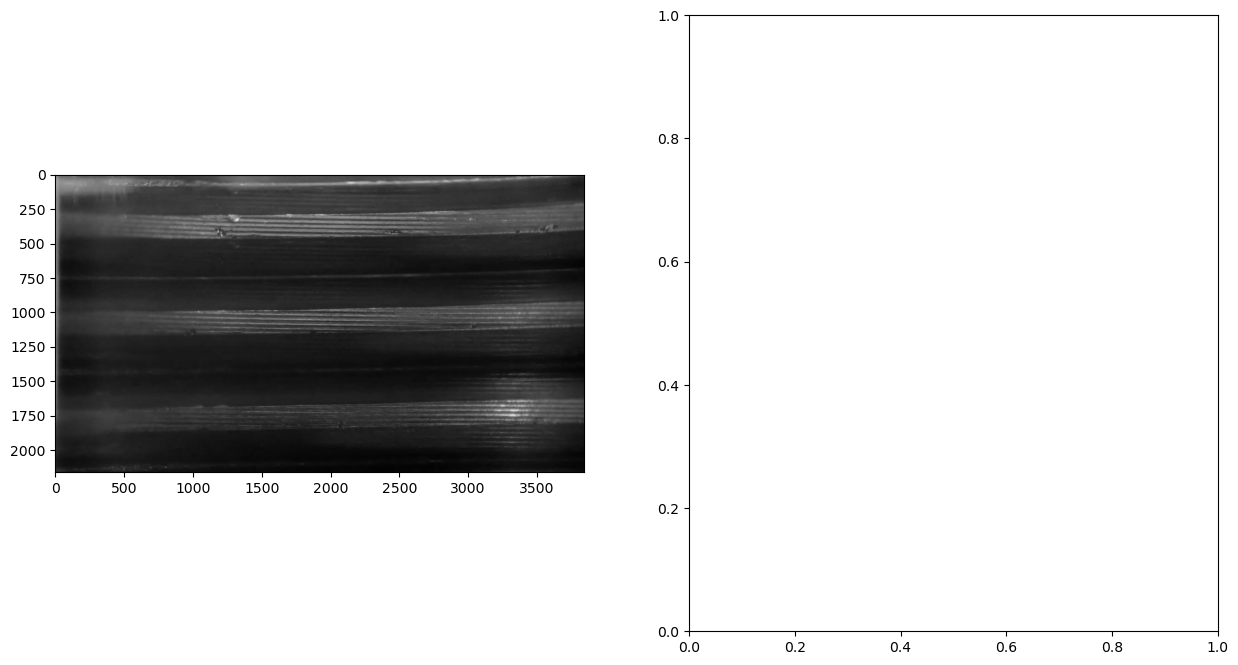

In [129]:
plt.figure(figsize=(15,8))

ax = plt.subplot(121)
ax.imshow(a[:, :,0], cmap="gray")
M = np.float32([
            [1, 0, (-shift_per_frame)],
            [0, 1, 0]
        ])
ax = plt.subplot(122)
ax.imshow((cv2.warpAffine(a1, M.T, (a1.shape[1], a1.shape[0])).astype(float) + a.astype(float))[:,:,0] // 2, cmap="gray")

plt.show()

In [109]:
per_frame_width = 20 # pixels taken from one image

In [110]:
FRAME_SIZE = a1.shape[:2]

In [111]:
FRAME_SIZE

(2160, 3840)

In [116]:
rows[0]

(array([  92, 2229]), array([2723, 4865]))

In [112]:
# TODO: create function with parameter CCW, CW

In [130]:
rows_images = []

for mn, mx in rows:
    row_image = np.zeros((FRAME_SIZE[0], np.ceil(frames_per_360 * shift_per_frame).astype(int) + FRAME_SIZE[1] // 2))
    weight_matrix = np.zeros(row_image.shape)
    
    start = mn + (mx - mn) // 2 - frames_per_360 // 2
    end = start + frames_per_360    
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
    success, image = vidcap.read()
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    print(f"processing frames {start}-{end}")

    for frameNo in tqdm(range(0, end - start)):
        M = np.float32([
            [1, 0, (shift_per_frame * frameNo)],
            [0, 1, 0]
        ])
        aligned_image = np.fliplr(cv2.warpAffine(image, M, (row_image.shape[1], row_image.shape[0])))
        crop_x_start = np.floor(row_image.shape[1] - image.shape[1] // 2 - per_frame_width // 2 - shift_per_frame * frameNo ).astype(int)
        crop_x_end = np.max([0, crop_x_start + per_frame_width])
        row_image[:, row_image.shape[1] - crop_x_end: row_image.shape[1] - crop_x_start] += aligned_image[:, crop_x_start:crop_x_end, 0]
        weight_matrix[:, row_image.shape[1] - crop_x_end: row_image.shape[1] - crop_x_start] += 1        
        frameNo += 1
        success, image = vidcap.read()
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
    rows_images.append(np.copy((row_image / weight_matrix)[:, image.shape[1] // 2: - per_frame_width // 2])) # crop the empty space

processing frames 188-2133


  0%|          | 0/1945 [00:00<?, ?it/s]

C:\Users\fathe\AppData\Local\Temp\ipykernel_20992\1107552471.py:29: RuntimeWarning: invalid value encountered in divide
  rows_images.append(np.copy((row_image / weight_matrix)[:, image.shape[1] // 2: - per_frame_width // 2])) # crop the empty space


processing frames 2822-4767


  0%|          | 0/1945 [00:00<?, ?it/s]

processing frames 5392-7337


  0%|          | 0/1945 [00:00<?, ?it/s]

processing frames 7838-9783


  0%|          | 0/1945 [00:00<?, ?it/s]

processing frames 10860-12805


  0%|          | 0/1945 [00:00<?, ?it/s]

In [131]:
SRC, video

('/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input', 'GX010998.MP4')

In [132]:
for iid, img in enumerate(rows_images):
    iio.imwrite(os.path.join(SRC, video).replace(".MP4", f"-zavit-{iid:02d}.png"), img.astype(np.uint8))

## Load images

In [ ]:
rows_images = []
for filename in sorted(os.listdir(SRC)):
    if "zavit" in filename and "png" in filename:
        rows_images.append(iio.imread(os.path.join(SRC, filename)))

In [196]:
# registration by mutual information
def mutual_information(imgA, imgB, bins=15):
    # taken from https://matthew-brett.github.io/teaching/mutual_information.html    
    hist_2d, x_edges, y_edges = np.histogram2d(
         imgA.ravel(),
         imgB.ravel(),
         bins=bins
    )
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def extract_images_and_compute_mi(shift, imgA, imgB, seed_position):    
    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + 399.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + 599.5)
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    # print(xg.shape, yg.shape)
    # print(interp.grid, interp.values.shape)
    # print(imgA.shape, seed_position)
    # print(imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
    #          seed_position[0, 1]: seed_position[0, 1] + 600].shape)
    return -mutual_information(
        imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
             seed_position[0, 1]: seed_position[0, 1] + 600].T,    
        interp((xg, yg))
    )

def to_minimize(x):
    return extract_images_and_compute_mi(shift=x, imgA=imgA, imgB=imgB, seed_position=seed_position)

def show_images(imgA, imgB, seed_position, shift):
    plt.figure(figsize=(15,5))
    ax = plt.subplot(131)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
                   seed_position[0, 1]: seed_position[0, 1] + 600].T, cmap="gray")
    ax.set_title("Fixed")

    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + 399.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + 599.5)    
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    
    ax = plt.subplot(132)
    ax.imshow(interp((xg, yg)), cmap="gray")
    ax.set_title("Moved")

    ax = plt.subplot(133)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
                   seed_position[0, 1]: seed_position[0, 1] + 600].T + interp((xg, yg)), cmap="gray")
    ax.set_title("Blend")
    plt.show()
               

In [191]:
physics = {
    "roll":  np.round(rows_images[0].shape[1] * 0.1).astype(int) + 40,
    "scan_shift": 2160 // 2 + 30,
    "screw_thread_distance": 400,
    "first_frame": [1600, 19800]
}

In [192]:
rows_images[0].shape, rows_images[1].shape

((2160, 20493), (2160, 20493))

In [193]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]
roll = physics["roll"]
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] - roll]]).astype(int)

In [194]:
seed_position

array([[ 1600, 19800],
       [  490, 17711]])

In [197]:
imgA = rows_images[0]
imgB = rows_images[1]
s1 = minimize(to_minimize, x0=np.array([0, 0]), method='COBYLA', bounds=[(-10, +10),(-10, 10)])

In [198]:
s1

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7194461031688753
       x: [-9.443e+00  2.599e+00]
    nfev: 44
   maxcv: 0.0

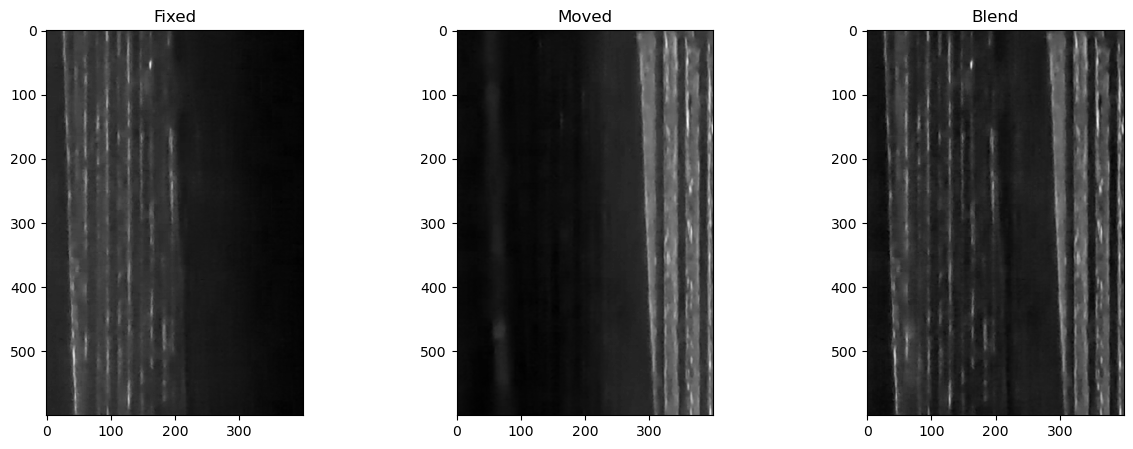

In [199]:
show_images(imgA, imgB, seed_position, s1.x)

In [200]:
screw_thread_distance = physics["screw_thread_distance"]
seed_position = np.array([[first_frame[0] - scan_shift + 2 * screw_thread_distance, first_frame[1] - roll],
                          [first_frame[0] - 2 * scan_shift + 2 * screw_thread_distance, first_frame[1] - 2 * roll]]).astype(int)
imgA = rows_images[1]
imgB = rows_images[2]
s2 = minimize(to_minimize, x0=[0,30], method='COBYLA', bounds=[(-10, 10),(-10, 40)])

In [201]:
s2

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.30966394576884676
       x: [-3.387e+00  3.007e+01]
    nfev: 35
   maxcv: 0.0

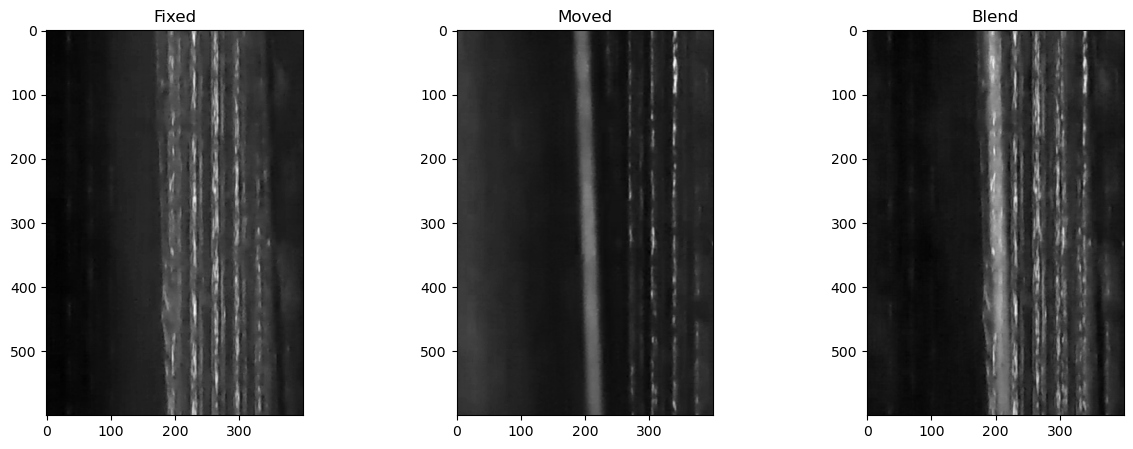

In [202]:
show_images(imgA, imgB, seed_position, s2.x)

In [203]:
[[first_frame[0] - 2 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 2 * roll], [first_frame[0] - 3 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 3 * roll]]

[[1380, 15622], [270, 13533]]

In [204]:
seed_position = np.array([[first_frame[0] - 2 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 2 * roll],
                          [first_frame[0] - 3 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 3 * roll]]).astype(int)
imgA = rows_images[2]
imgB = rows_images[3]
s3 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [205]:
s3

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.5032670398602137
       x: [-5.909e+00  9.171e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [-7.811e-01 -2.849e-01]]
    nfev: 120

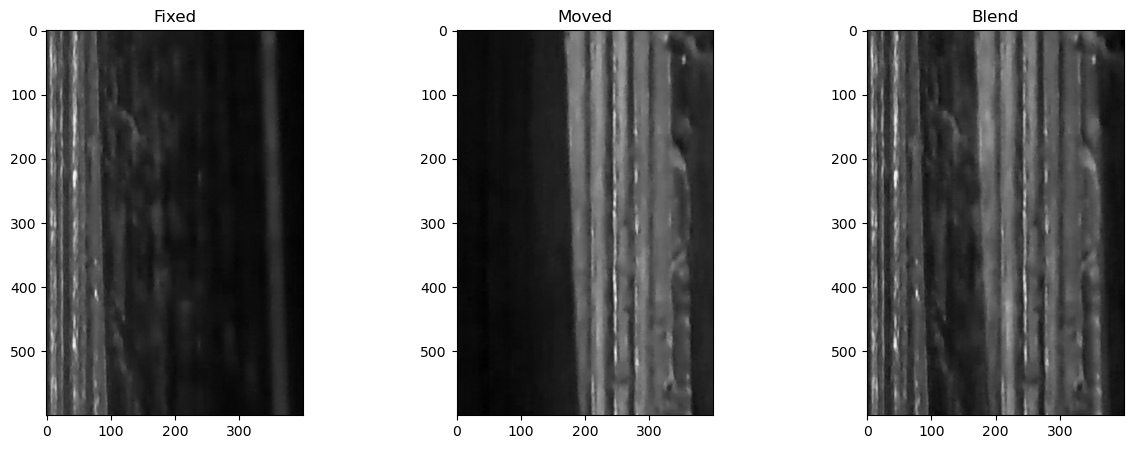

In [206]:
show_images(imgA, imgB, seed_position, s3.x)

In [207]:
[[first_frame[0] - 3 * scan_shift + 9 * screw_thread_distance, first_frame[1] - 3 * roll],
                          [first_frame[0] - 4 * scan_shift + 9 * screw_thread_distance, first_frame[1] - 4 * roll]]

[[1870, 13533], [760, 11444]]

In [208]:
seed_position = np.array([[first_frame[0] - 3 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 3 * roll],
                          [first_frame[0] - 4 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 4 * roll]]).astype(int)
imgA = rows_images[3]
imgB = rows_images[4]
s4 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [209]:
s4

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.26534815915244425
       x: [-2.336e+00  3.546e+01]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 151

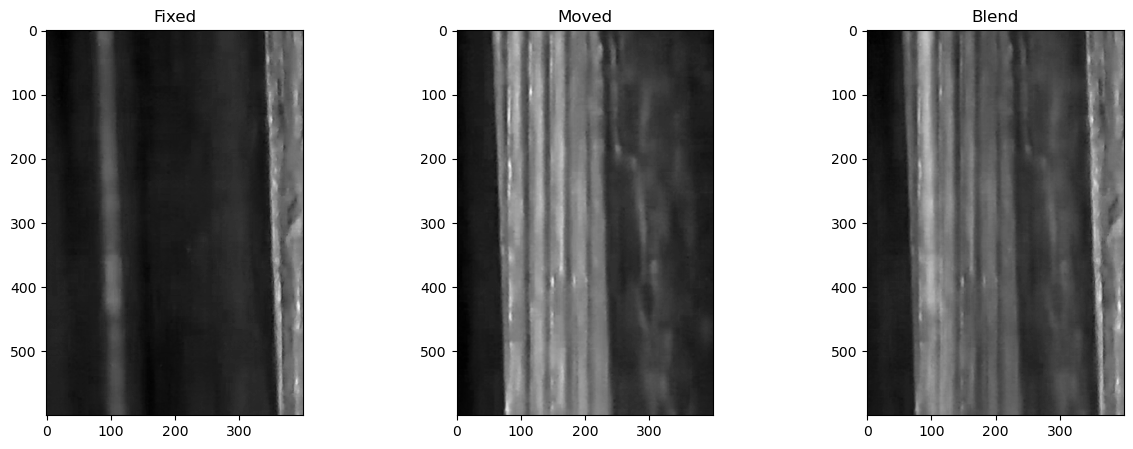

In [210]:
show_images(imgA, imgB, seed_position, s4.x)

In [211]:
[[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
 [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]

[[1560, 11444], [450, 9355]]

In [212]:
seed_position = np.array([[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
                          [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]).astype(int)
imgA = rows_images[4]
imgB = rows_images[5]
s5 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

IndexError: list index out of range

In [ ]:
s5

In [ ]:
show_images(imgA, imgB, seed_position, s5.x)

In [213]:
[[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
 [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]

[[1250, 9355], [140, 7266]]

In [ ]:
seed_position = np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                          [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int)
imgA = rows_images[5]
imgB = rows_images[6]
s6 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s6

In [ ]:
show_images(imgA, imgB, seed_position, s6.x)

In [214]:
shift_fixes = np.array([s1.x, s2.x, s3.x, s4.x])

## Merge

- sesbírat posun per row
- aggregovats `sn.x`
- provést roll každé otočky + interpolaci
- vyrobit váhovou matici pro překryv
- vynásobit / flatnout

In [215]:
shift_seed = []
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] - roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - scan_shift + 2 * screw_thread_distance, first_frame[1] - roll],
                            [first_frame[0] - 2 * scan_shift + 2 * screw_thread_distance, first_frame[1] - 2 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 2 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 2 * roll],
                            [first_frame[0] - 3 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 3 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 3 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 3 * roll],
                            [first_frame[0] - 4 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 4 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
                            [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                            [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int))

In [216]:
per_row_shift = np.array([seed[0, :] - seed[1, :] - fix for seed, fix in zip(shift_seed, shift_fixes)])

In [217]:
per_row_shift

array([[1119.44345915, 2086.40127708],
       [1113.38653204, 2058.92708877],
       [1115.90929936, 2079.82900736],
       [1112.33627362, 2053.53831355]])

In [220]:
def real_roll(array, shift, axis=0):    
    double_image = np.concatenate([array, array], axis=1)
    interp = RegularGridInterpolator(
        (np.arange(double_image.shape[0]), np.arange(double_image.shape[1])), 
        double_image
    )
    if shift > 0:
        y = np.arange(shift, shift + array.shape[1] - 0.5, 1)
    else:
        y = np.arange(shift + array.shape[1], 2 * array.shape[1] + shift - 0.5, 1)    
    x = np.arange(array.shape[0])    
    xg, yg = np.meshgrid(x, y)    
    return interp((xg, yg)).T

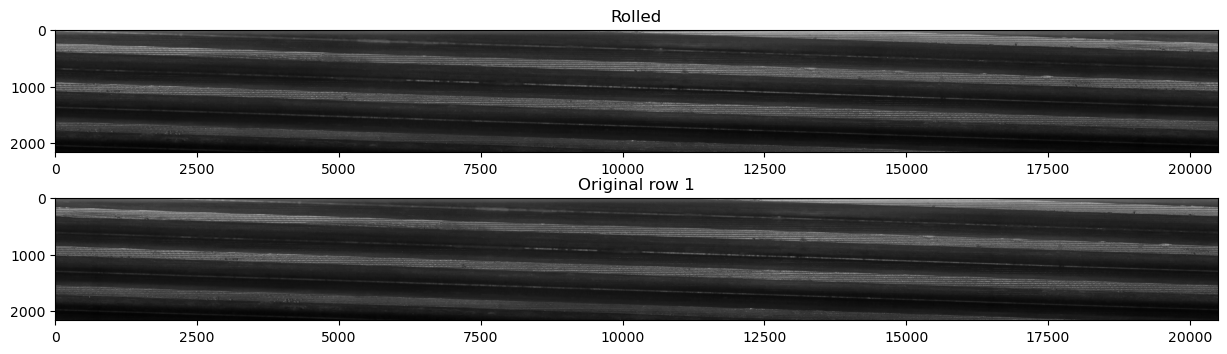

In [221]:
# Test of the real roll function
plt.figure(figsize=(15,4))
ax = plt.subplot(211)
ax.imshow(real_roll(rows_images[1], per_row_shift[0,1]), cmap="gray")
ax.set_title("Rolled")
ax = plt.subplot(212)
ax.imshow(rows_images[1], cmap="gray")
ax.set_title("Original row 1")
plt.show()

In [222]:
rows_images[0].shape

(2160, 20493)

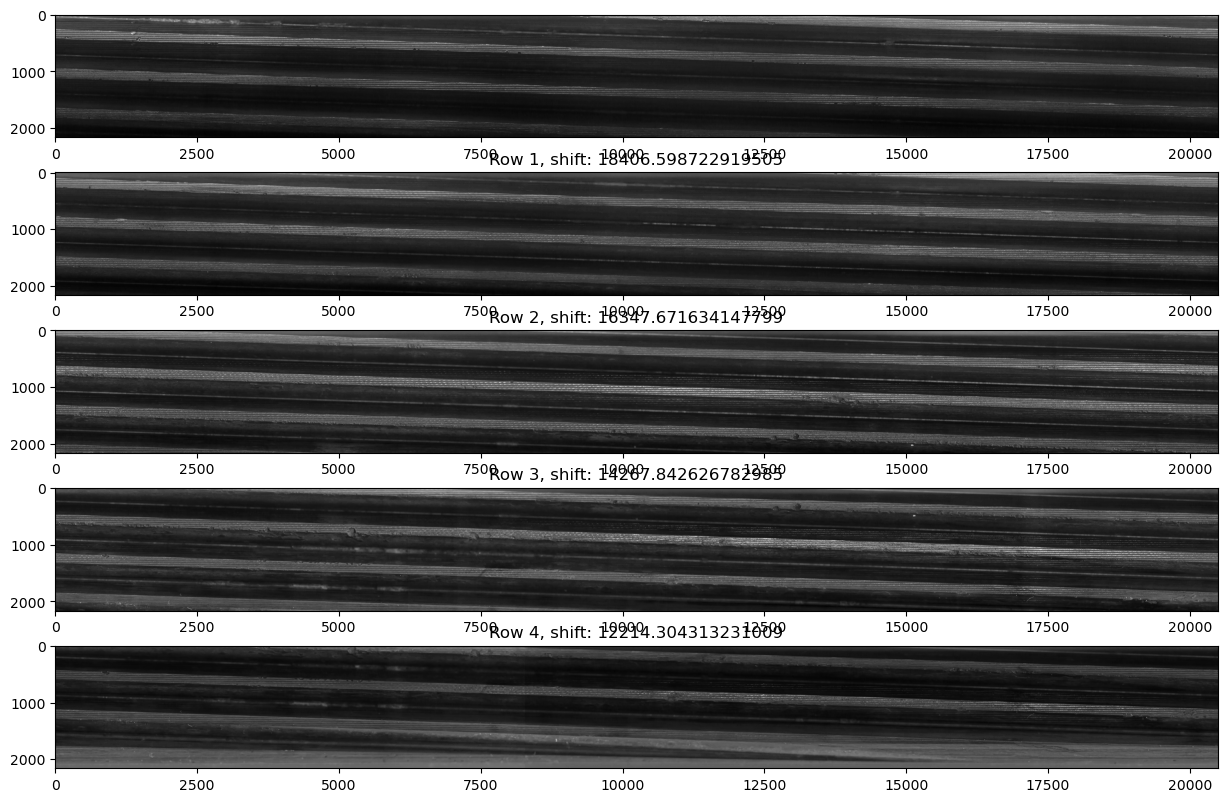

In [223]:
rolled = []
# Roll all rows as required and plot them
plt.figure(figsize=(15,14))
ax = plt.subplot(7, 1, 1)
ax.imshow(rows_images[0], cmap="gray")
rolled.append(rows_images[0])
for en, row_shift in enumerate(np.cumsum(-per_row_shift[:,1])):
    ax = plt.subplot(7, 1, en+2)
    rolled.append(real_roll(rows_images[en + 1], row_shift % rows_images[en + 1].shape[1]))
    ax.imshow(rolled[-1], cmap="gray")
    ax.set_title(f"Row {en + 1}, shift: {row_shift % rows_images[en + 1].shape[1]}")
plt.show()

In [224]:
# merge rows

In [225]:
to_grid = [rolled[0]]
real_shift = [0]
for image, shift in tqdm(zip(rolled[1:], np.cumsum(per_row_shift[:,0])), total=per_row_shift.shape[0]):
    interp = RegularGridInterpolator(
        (np.arange(image.shape[0]), np.arange(image.shape[1])), 
        image
    )
    x = np.arange(image.shape[0] - 1)
    y = np.arange(image.shape[1])
    xg, yg = np.meshgrid(x,y)
    to_grid.append(interp((xg, yg)).T)
    real_shift.append(int(shift // 1))


  0%|          | 0/4 [00:00<?, ?it/s]

In [226]:
out_height = rolled[0].shape[0] + np.max(real_shift)

In [227]:
full_image = np.zeros((out_height, rolled[0].shape[1], len(rolled)))
for en, (image, r_shift) in enumerate(zip(to_grid, real_shift)):
    full_image[r_shift: r_shift + image.shape[0], :, en] = image

In [228]:
blend_matrix = np.zeros((out_height, to_grid[0].shape[1], len(to_grid)))

blend_matrix[:real_shift[1], :, 0] += 1
lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[0].shape[0] - real_shift[1])).reshape(-1, 1), 
                   np.ones((to_grid[0].shape[1],1)).T)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 0] += np.flipud(lin_blend)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 1] += lin_blend

for en, (image, r_shift) in enumerate(list(zip(to_grid, real_shift))[:-2]):
    blend_matrix[real_shift[en] + to_grid[en].shape[0]: real_shift[en + 2], :, en + 1] += 1
    lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[en + 1].shape[0] + real_shift[en + 1] - real_shift[en + 2])).reshape(-1, 1), 
                       np.ones((to_grid[en + 1].shape[1],1)).T)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 1] += np.flipud(lin_blend)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 2] += lin_blend

blend_matrix[to_grid[en + 1].shape[0] + real_shift[en + 1]:, :, -1] += 1

In [229]:
blended_full_image = np.sum(full_image * blend_matrix, axis=2) / np.sum(blend_matrix, axis=2)

## Conclusion - Image READY

In [230]:
iio.imwrite(os.path.join(SRC, video).replace(".MP4", "oio.png"), blended_full_image.astype(np.uint8))

# Rotate to diff

In [231]:
edges = cv2.Canny(blended_full_image.astype(np.uint8),80,200)

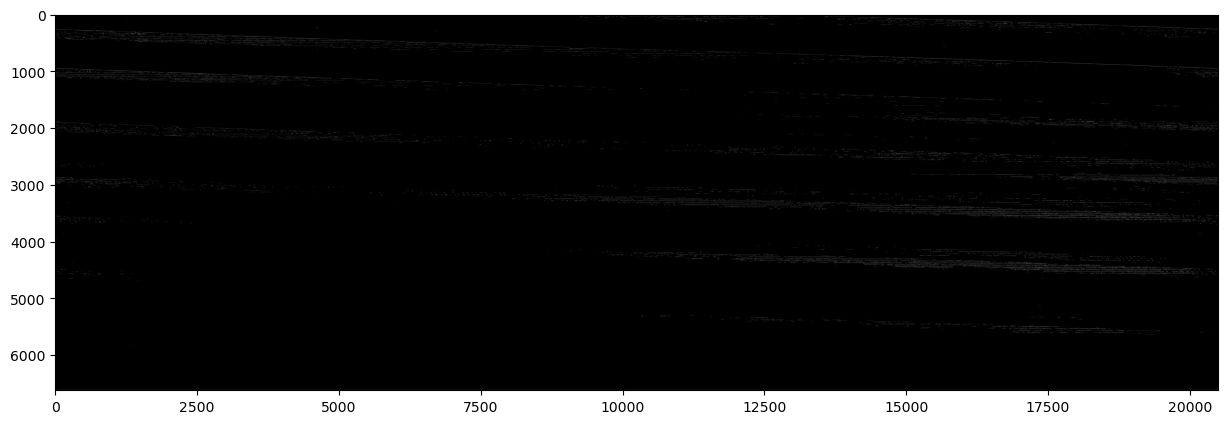

In [232]:
plt.figure(figsize=(15,8))
plt.imshow(edges, cmap="gray")
plt.show()

In [233]:
lines = cv2.HoughLines(edges, 10, np.pi/1800, 1, min_theta=4/5 * np.pi, max_theta=np.pi)


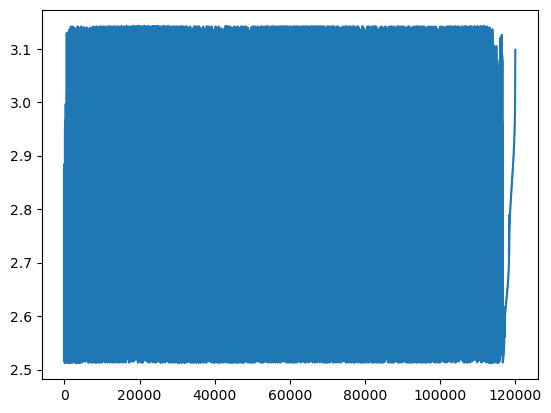

In [234]:
plt.plot(lines[:,0,1])
plt.show()

### Odbočka - copak je v GPMF datech

In [ ]:
import gpmf
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import butter, sosfilt

In [ ]:
gpmf_stream = gpmf.io.extract_gpmf_stream(os.path.join(SRC, videos[0]))

In [ ]:
stream_content = []
for s in gpmf.parse.filter_klv(gpmf_stream, "GYRO"):
    content = []
    is_gyro = False
    for elt in s.value:
        content.append(elt)
        
    stream_content.append(content)

In [ ]:
len(stream_content) * 207

In [ ]:
len(stream_content[0])

In [ ]:
plt.figure(figsize=(15,5))
ax=plt.subplot(111)
x = gaussian([np.mean([x for x, _, _ in content]) for content in stream_content], 1)
ax.plot(x - np.mean(x), label="horizontal")
y = gaussian([np.mean([x for _, x, _ in content]) for content in stream_content], 1)
ax.plot(y - np.mean(y), label="lens axis")
z = gaussian([np.mean([x for _, _, x in content]) for content in stream_content], 1)
ax.plot(z - np.mean(z), label="vertical")
plt.ylabel("rad/s")
plt.xlabel("video time (x)")
plt.legend()
plt.show()

In [ ]:
from pykalman import KalmanFilter

In [ ]:
kf = KalmanFilter(n_dim_obs=1, em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean'])

In [ ]:
plt.plot(np.arange(0, len(y), 10), kf.em(y, n_iter=10).smooth(y[::10])[0].reshape(-1))
plt.plot(buttap(y))
plt.show()

In [ ]:
sos = butter(1, 60, 'hp', fs=1000, output='sos')
filtered = sosfilt(sos, y)

In [ ]:
plt.plot(filtered)
plt.plot(y)
plt.show()